In [1]:
import kagglehub

path = kagglehub.dataset_download(
    "kaustubhdikshit/neu-surface-defect-database"
)

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'neu-surface-defect-database' dataset.
Path to dataset files: /kaggle/input/neu-surface-defect-database


In [2]:
!pip install ultralytics opencv-python numpy tqdm scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 54.3 MB/s eta 0:00:00


In [3]:

import os
NEU_ROOT = path+"/NEU-DET"


YOLO_ROOT = "dataset_yolo"


CLASSES = [
    "crazing",
    "inclusion",
    "patches",
    "pitted_surface",
    "rolled-in_scale",
    "scratches"
]

CLASS_MAP = {name: idx for idx, name in enumerate(CLASSES)}

for split in ["train", "val"]:
    os.makedirs(f"{YOLO_ROOT}/images/{split}", exist_ok=True)
    os.makedirs(f"{YOLO_ROOT}/labels/{split}", exist_ok=True)


In [4]:
import cv2
import numpy as np
import xml.etree.ElementTree as ET
from tqdm import tqdm
import glob
import random
import matplotlib.pyplot as plt


In [5]:
def apply_clahe(img):
    clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8, 8))
    return clahe.apply(img)

def motion_blur(img, k=np.random.choice([3, 5, 6])):
    kernel = np.zeros((k, k))
    kernel[k // 2, :] = np.ones(k)
    kernel /= k
    return cv2.filter2D(img, -1, kernel)

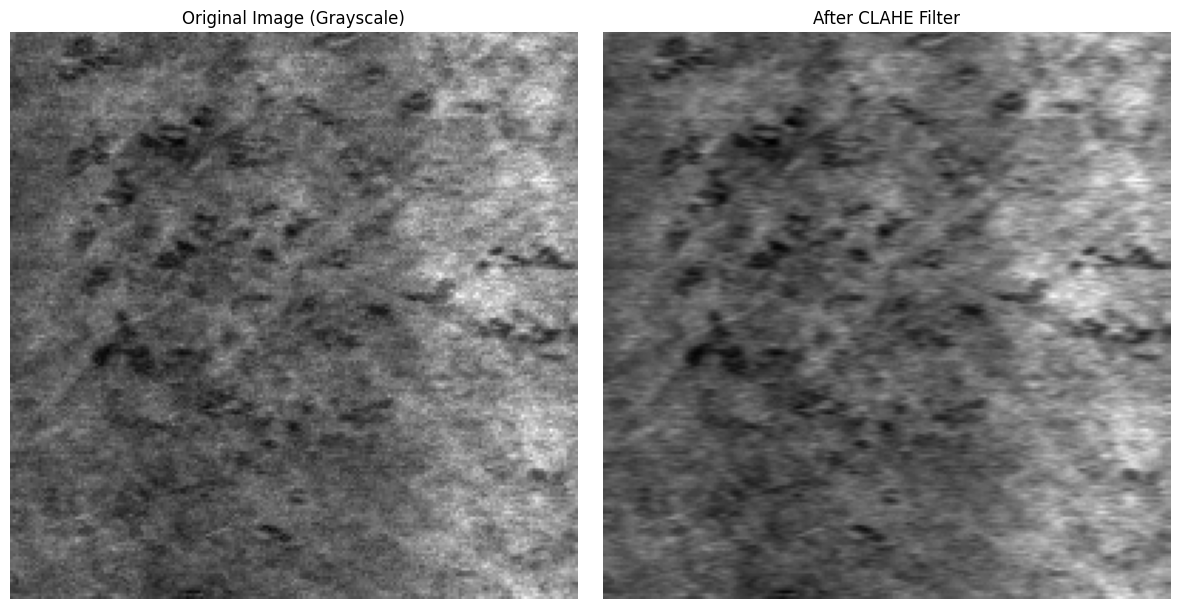

In [6]:
all_images = glob.glob(f"{NEU_ROOT}/train/images/*/rolled-in_scale_225.jpg")

if not all_images:
    print("Not found")
else:
    random_img_path = random.choice(all_images)
    original_img = cv2.imread(random_img_path, cv2.IMREAD_GRAYSCALE)
    processed_img = motion_blur(original_img)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img, cmap='gray')
    plt.title("Original Image (Grayscale)")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(processed_img, cmap='gray')
    plt.title("After CLAHE Filter")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

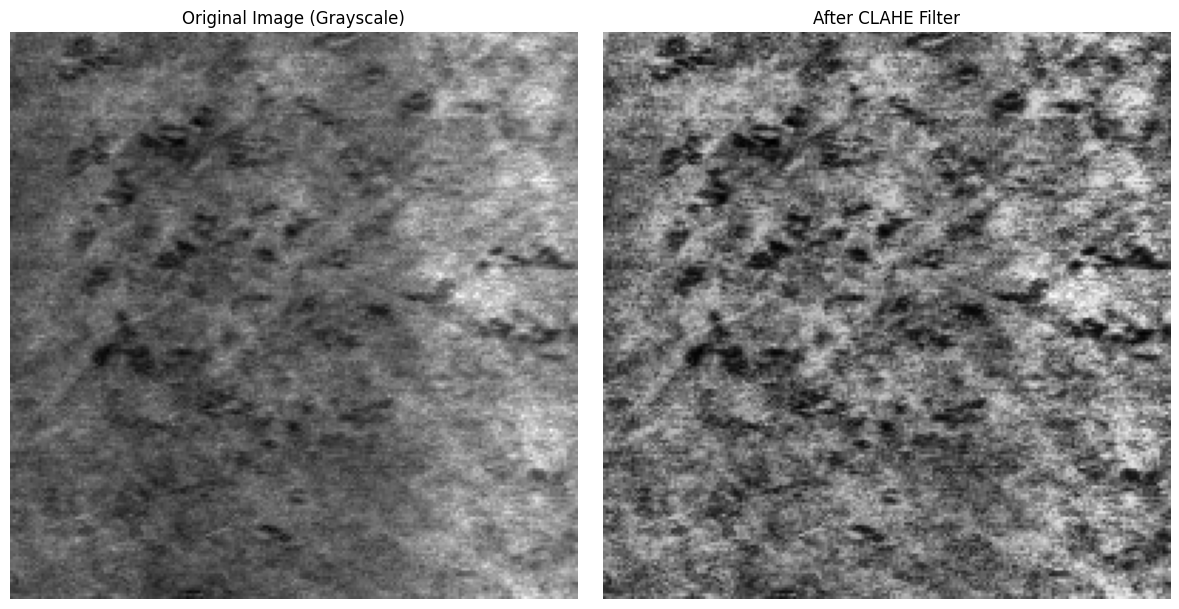

In [7]:
all_images = glob.glob(f"{NEU_ROOT}/train/images/*/rolled-in_scale_225.jpg")

if not all_images:
    print("Not found")
else:
    random_img_path = random.choice(all_images)
    original_img = cv2.imread(random_img_path, cv2.IMREAD_GRAYSCALE)
    processed_img = apply_clahe(original_img)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img, cmap='gray')
    plt.title("Original Image (Grayscale)")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(processed_img, cmap='gray')
    plt.title("After CLAHE Filter")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [8]:
def voc_to_yolo(xml_path, img_w, img_h):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    labels = []

    for obj in root.findall("object"):
        cls_name = obj.find("name").text
        cls_id = CLASS_MAP[cls_name]

        b = obj.find("bndbox")
        xmin, ymin = float(b.find("xmin").text), float(b.find("ymin").text)
        xmax, ymax = float(b.find("xmax").text), float(b.find("ymax").text)

        xc = ((xmin + xmax) / 2) / img_w
        yc = ((ymin + ymax) / 2) / img_h
        w = (xmax - xmin) / img_w
        h = (ymax - ymin) / img_h

        labels.append(f"{cls_id} {xc:.6f} {yc:.6f} {w:.6f} {h:.6f}")

    return labels

In [9]:
def process_train():
    img_root = f"{NEU_ROOT}/train/images"
    ann_root = f"{NEU_ROOT}/train/annotations"

    for cls in CLASSES:
        img_dir = f"{img_root}/{cls}"
        if not os.path.exists(img_dir): continue

        for img_name in tqdm(os.listdir(img_dir), desc=f"Processing {cls}"):
            img_path = os.path.join(img_dir, img_name)


            base_name = os.path.splitext(img_name)[0]
            xml_path = os.path.join(ann_root, f"{base_name}.xml")

            if not os.path.exists(xml_path):
                continue

            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None: continue
            h, w = img.shape

            img = apply_clahe(img)


            if np.random.rand() < 0.3:
                img = motion_blur(img, k=np.random.choice([3, 5, 7]))

            if np.random.rand() < 0.1:
                sigma = np.random.uniform(2, 10)
                noise = np.random.normal(0, sigma, (h, w)).astype(np.int16)
                img = np.clip(img.astype(np.int16) + noise, 0, 255).astype(np.uint8)

            cv2.imwrite(f"{YOLO_ROOT}/images/train/{base_name}.jpg", img)

            labels = voc_to_yolo(xml_path, w, h)
            with open(f"{YOLO_ROOT}/labels/train/{base_name}.txt", "w") as f:
                f.write("\n".join(labels))

In [10]:
def process_val():
    img_root = f"{NEU_ROOT}/validation/images"
    ann_root = f"{NEU_ROOT}/validation/annotations"

    for cls in CLASSES:
        img_dir = f"{img_root}/{cls}"
        if not os.path.exists(img_dir): continue

        for img_name in tqdm(os.listdir(img_dir), desc=f"Val {cls}"):
            img_path = os.path.join(img_dir, img_name)

            base_name = os.path.splitext(img_name)[0]
            xml_path = os.path.join(ann_root, f"{base_name}.xml")

            if not os.path.exists(xml_path):
                continue

            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None: continue
            h, w = img.shape

            img = apply_clahe(img)

            cv2.imwrite(f"{YOLO_ROOT}/images/val/{base_name}.jpg", img)

            labels = voc_to_yolo(xml_path, w, h)
            with open(f"{YOLO_ROOT}/labels/val/{base_name}.txt", "w") as f:
                f.write("\n".join(labels))

In [ ]:
print(len(os.listdir(f"{NEU_ROOT}/train/annotations")))
print(len(os.listdir(f"{NEU_ROOT}/validation/annotations")))

1439
361


In [ ]:
process_train()
process_val()
print("Dataset Prepared")

Val scratches: 100%|██████████| 60/60 [00:00<00:00, 74.53it/s]

Dataset Prepared


In [ ]:
import shutil

zip_file_name = "NEU_DET_YOLO_Ready"

shutil.make_archive(zip_file_name, 'zip', YOLO_ROOT)


print(f"✅ Saved {zip_file_name}.zip")
print(f" {os.path.getsize(zip_file_name + '.zip') / (1024*1024):.2f} MB")

✅ Saved NEU_DET_YOLO_Ready.zip
 36.03 MB


In [11]:
import os
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:


destination_path = '/content/drive/MyDrive/FINAL_Project/Dataset'
zip_file_name = "NEU_DET_YOLO_Ready.zip"

if not os.path.exists(destination_path):
    os.makedirs(destination_path)
else:
    print(f"Done")
source_file = f"{zip_file_name}"
final_destination = os.path.join(destination_path, zip_file_name)

!cp {source_file} "{final_destination}"

!cp -r {YOLO_ROOT} "{destination_path}"
!cp -r {NEU_ROOT} "{destination_path}"

if os.path.exists(final_destination):
    print(f"Coppied into: {final_destination}")
else:
    print(f"Error")

Done
cp: cannot stat 'NEU_DET_YOLO_Ready.zip': No such file or directory
^C
^C
Coppied into: /content/drive/MyDrive/FINAL_Project/Dataset/NEU_DET_YOLO_Ready.zip


In [12]:
import os
import zipfile

drive_zip_path = '/content/drive/MyDrive/FINAL_Project/Dataset/NEU_DET_YOLO_Ready.zip'
local_zip_path = '/content/dataset_yolo.zip'
extract_to = YOLO_ROOT

if os.path.exists(drive_zip_path):
    !cp "{drive_zip_path}" {local_zip_path}

else:
    print("Not found")

if not os.path.exists(extract_to):
    os.makedirs(extract_to)

!unzip -q {local_zip_path} -d {extract_to}

!ls {extract_to}

images	labels


In [13]:
with open("data.yaml", "w") as f:
    f.write("""
path: dataset_yolo
train: images/train
val: images/val

nc: 6
names:
  - crazing
  - inclusion
  - patches
  - pitted_surface
  - rolled-in_scale
  - scratches
""")


In [14]:
import torch
import torch.nn as nn

class GSEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()

        self.f = None
        self.i = None
        self.type = "GSE"

        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(channels, channels // reduction, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // reduction, channels, 1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return x * self.fc(self.gap(x))


In [15]:
class GSEBlock_Improved(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.gmp = nn.AdaptiveMaxPool2d(1)

        self.fc = nn.Sequential(
            nn.Conv2d(channels, channels // reduction, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // reduction, channels, 1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        avg_out = self.gap(x)
        max_out = self.gmp(x)
        scale = self.fc(avg_out + max_out)
        return x * scale

In [ ]:
from ultralytics.nn.modules import SPPF

if not hasattr(SPPF, "_gse_patched"):

    SPPF._orig_forward = SPPF.forward

    def sppf_forward_with_gse(self, x):
        y = SPPF._orig_forward(self, x)

        if not hasattr(self, "gse"):
            self.gse = GSEBlock_Improved(y.shape[1]).to(y.device)

        return self.gse(y)

    SPPF.forward = sppf_forward_with_gse
    SPPF._gse_patched = True


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
from ultralytics import YOLO
model = YOLO("yolov8n.pt")
model.train(
    data="data.yaml",
    epochs=300,
    imgsz=640,
    batch=16,
    optimizer="AdamW",
    lr0=1e-3,
    lrf=0.01,
    cos_lr=True,
    warmup_epochs=5,

    mosaic=0.0,
    mixup=0.0,
    cutmix=0.0,
    fliplr=0.5,
    flipud=0.5,
    scale=0.3,


    hsv_h=0.0, hsv_s=0.0, hsv_v=0.0,
    patience=50,
    device=0,

    project="/content/drive/MyDrive/FINAL_Project/Training_Results",
    name="YOLO_GSE_v1"
)

Ultralytics 8.4.12 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=300, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.0, hsv_s=0.0, hsv_v=0.0, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=0.0, multi_scale=0.0, name=YOLO_GSE_v14, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=50, perspective=0.0, plots=True, 

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      1/300      2.02G      1.929      3.024      2.033         47        640: 100% ━━━━━━━━━━━━ 90/90 4.0it/s 22.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 3.3it/s 3.6s
                   all        360        854      0.347      0.332      0.276      0.126

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      2/300      2.49G      1.622      2.133       1.72         36        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      2/300      2.49G      1.765      2.087      1.844         31        640: 100% ━━━━━━━━━━━━ 90/90 4.5it/s 19.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 5.0it/s 2.4s
                   all        360        854      0.632       0.35      0.351      0.151

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      3/300      2.51G      1.703      2.122      1.867         42        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      3/300      2.51G       1.77      2.005      1.848         33        640: 100% ━━━━━━━━━━━━ 90/90 4.6it/s 19.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 3.3it/s 3.6s
                   all        360        854      0.521        0.4        0.4      0.185

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      4/300      2.53G      1.569      1.802      1.683         38        640: 1% ──────────── 1/90 1.9it/s 0.3s<47.8s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      4/300      2.53G      1.723      1.928      1.836         35        640: 100% ━━━━━━━━━━━━ 90/90 4.8it/s 18.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 5.0it/s 2.4s
                   all        360        854      0.209      0.494       0.26     0.0988

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      5/300      2.53G      1.572      1.846      1.764         33        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      5/300      2.55G      1.753      1.883      1.846         32        640: 100% ━━━━━━━━━━━━ 90/90 4.6it/s 19.7s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 4.5it/s 2.7s
                   all        360        854      0.757      0.312       0.46      0.198

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      6/300      2.56G      1.725      2.167      1.794         34        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      6/300      2.56G      1.736       1.86      1.832         30        640: 100% ━━━━━━━━━━━━ 90/90 4.8it/s 18.7s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 5.0it/s 2.4s
                   all        360        854      0.508      0.329      0.343      0.155

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      7/300      2.58G        1.7      1.695      1.845         31        640: 1% ──────────── 1/90 1.9it/s 0.3s<47.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      7/300      2.58G      1.687      1.779      1.799         37        640: 100% ━━━━━━━━━━━━ 90/90 4.6it/s 19.7s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 5.0it/s 2.4s
                   all        360        854      0.419       0.56      0.496      0.199

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      8/300       2.6G      1.449      1.592      1.667         38        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      8/300       2.6G      1.654      1.716      1.778         34        640: 100% ━━━━━━━━━━━━ 90/90 4.8it/s 18.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 4.6it/s 2.6s
                   all        360        854       0.65      0.405      0.501      0.209

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      9/300      2.61G      1.669      1.599      1.818         37        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      9/300      2.62G       1.66      1.671      1.766         34        640: 100% ━━━━━━━━━━━━ 90/90 4.6it/s 19.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 5.0it/s 2.4s
                   all        360        854      0.635      0.448      0.538      0.236

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     10/300      2.63G      1.653      1.751       1.78         43        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     10/300      2.63G      1.652      1.662      1.765         28        640: 100% ━━━━━━━━━━━━ 90/90 4.7it/s 19.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 3.4it/s 3.6s
                   all        360        854      0.491      0.554      0.537      0.235

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     11/300      2.65G      1.747      1.728      1.844         53        640: 1% ──────────── 1/90 1.9it/s 0.3s<46.3s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     11/300      2.65G      1.614      1.661      1.728         30        640: 100% ━━━━━━━━━━━━ 90/90 4.9it/s 18.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 5.0it/s 2.4s
                   all        360        854      0.482      0.603       0.57      0.252

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     12/300      2.66G      2.028       2.13      2.036         38        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     12/300      2.67G      1.603      1.623      1.734         39        640: 100% ━━━━━━━━━━━━ 90/90 4.6it/s 19.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 4.1it/s 2.9s
                   all        360        854      0.472      0.603      0.561      0.257

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     13/300      2.68G      1.592      1.773      1.672         39        640: 0% ──────────── 0/90  0.1s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     13/300      2.68G      1.615      1.613      1.735         32        640: 100% ━━━━━━━━━━━━ 90/90 4.8it/s 18.7s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 4.9it/s 2.4s
                   all        360        854      0.613       0.46      0.509      0.224

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     14/300       2.7G      1.876      1.761      1.854         36        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     14/300       2.7G      1.585      1.557      1.694         30        640: 100% ━━━━━━━━━━━━ 90/90 4.5it/s 20.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 5.0it/s 2.4s
                   all        360        854      0.497        0.6      0.599      0.283

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     15/300      2.72G      1.366      1.382      1.587         30        640: 0% ──────────── 0/90  0.1s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     15/300      2.72G      1.568      1.541      1.696         38        640: 100% ━━━━━━━━━━━━ 90/90 4.8it/s 18.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 4.8it/s 2.5s
                   all        360        854       0.54      0.525      0.597       0.28

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     16/300      2.73G      1.574       1.23      1.763         35        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     16/300      2.73G      1.576      1.527      1.688         40        640: 100% ━━━━━━━━━━━━ 90/90 4.6it/s 19.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 4.9it/s 2.4s
                   all        360        854      0.552      0.588      0.575      0.262

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     17/300      2.75G      1.441       1.61      1.635         36        640: 0% ──────────── 0/90  0.1s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     17/300      2.75G      1.557      1.519      1.687         41        640: 100% ━━━━━━━━━━━━ 90/90 4.8it/s 18.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 3.9it/s 3.1s
                   all        360        854      0.711      0.489        0.6      0.291

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     18/300      2.77G      1.678      1.822      1.942         29        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     18/300      2.77G      1.517      1.504      1.668         36        640: 100% ━━━━━━━━━━━━ 90/90 4.8it/s 18.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 5.0it/s 2.4s
                   all        360        854      0.531      0.583      0.593      0.278

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     19/300      2.78G      1.669      1.395      1.723         39        640: 0% ──────────── 0/90  0.1s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     19/300      2.79G      1.519       1.46      1.663         29        640: 100% ━━━━━━━━━━━━ 90/90 4.8it/s 18.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 3.4it/s 3.5s
                   all        360        854       0.58      0.563      0.606      0.284

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     20/300       2.8G       1.42      1.321      1.484         39        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     20/300       2.8G      1.531      1.464       1.67         35        640: 100% ━━━━━━━━━━━━ 90/90 4.9it/s 18.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 5.0it/s 2.4s
                   all        360        854       0.48      0.645      0.609      0.285

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     21/300      2.82G       1.59      1.453      1.746         45        640: 1% ──────────── 1/90 1.9it/s 0.3s<46.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     21/300      2.82G      1.535      1.446      1.663         39        640: 100% ━━━━━━━━━━━━ 90/90 4.6it/s 19.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 4.2it/s 2.9s
                   all        360        854      0.575      0.629       0.63        0.3

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     22/300      2.84G      1.747      1.652      1.795         37        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     22/300      2.84G       1.52      1.437      1.655         43        640: 100% ━━━━━━━━━━━━ 90/90 4.8it/s 18.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 5.0it/s 2.4s
                   all        360        854      0.553      0.622      0.632      0.307

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     23/300      2.85G      1.219      1.122      1.614         31        640: 0% ──────────── 0/90  0.1s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     23/300      2.85G      1.519      1.432      1.652         34        640: 100% ━━━━━━━━━━━━ 90/90 4.4it/s 20.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 5.0it/s 2.4s
                   all        360        854      0.537       0.62      0.625      0.297

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     24/300      2.87G      1.475      1.218       1.45         40        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     24/300      2.87G      1.505      1.432      1.638         35        640: 100% ━━━━━━━━━━━━ 90/90 4.9it/s 18.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 4.9it/s 2.4s
                   all        360        854      0.494      0.563      0.549       0.26

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     25/300      2.89G      1.365      1.269      1.528         39        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     25/300      2.89G      1.485      1.405      1.615         39        640: 100% ━━━━━━━━━━━━ 90/90 4.5it/s 19.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 5.0it/s 2.4s
                   all        360        854      0.724      0.548      0.663      0.319

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     26/300      2.91G      1.624      1.902      1.786         37        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     26/300      2.91G      1.487       1.39      1.635         27        640: 100% ━━━━━━━━━━━━ 90/90 4.8it/s 18.7s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 3.4it/s 3.6s
                   all        360        854      0.696      0.525       0.63      0.309

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     27/300      2.92G      1.495      1.352      1.652         38        640: 1% ──────────── 1/90 2.0it/s 0.3s<44.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     27/300      2.92G      1.483      1.377      1.619         33        640: 100% ━━━━━━━━━━━━ 90/90 4.9it/s 18.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 5.0it/s 2.4s
                   all        360        854      0.574      0.622      0.643      0.311

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     28/300      2.94G      1.515      1.357      1.534         36        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     28/300      2.94G      1.498       1.39      1.628         33        640: 100% ━━━━━━━━━━━━ 90/90 4.7it/s 19.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 3.7it/s 3.2s
                   all        360        854      0.535      0.589      0.602      0.289

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     29/300      2.96G      1.442      1.554      1.643         37        640: 0% ──────────── 0/90  0.1s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     29/300      2.96G      1.457      1.354        1.6         36        640: 100% ━━━━━━━━━━━━ 90/90 4.9it/s 18.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 4.8it/s 2.5s
                   all        360        854      0.585      0.643      0.648      0.326

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     30/300      2.97G       1.39      1.161      1.524         38        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     30/300      2.97G      1.462      1.375      1.618         38        640: 100% ━━━━━━━━━━━━ 90/90 4.5it/s 20.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 4.9it/s 2.5s
                   all        360        854      0.739      0.528      0.667      0.322

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     31/300      2.99G      1.422      1.267      1.483         43        640: 1% ──────────── 1/90 1.9it/s 0.3s<47.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     31/300      2.99G      1.465      1.353      1.605         34        640: 100% ━━━━━━━━━━━━ 90/90 4.8it/s 18.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 4.9it/s 2.5s
                   all        360        854      0.577      0.618      0.662      0.327

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     32/300      3.01G      1.399       1.29      1.489         35        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     32/300      3.01G      1.447      1.336      1.594         34        640: 100% ━━━━━━━━━━━━ 90/90 4.5it/s 20.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 5.1it/s 2.4s
                   all        360        854      0.578      0.664      0.655      0.317

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     33/300      3.02G      1.453      1.161      1.471         38        640: 0% ──────────── 0/90  0.1s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     33/300      3.03G      1.444      1.321      1.584         25        640: 100% ━━━━━━━━━━━━ 90/90 4.8it/s 18.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 3.4it/s 3.6s
                   all        360        854      0.542      0.638      0.642      0.319

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     34/300      3.04G      1.418      1.171       1.62         37        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     34/300      3.04G      1.432      1.293      1.584         28        640: 100% ━━━━━━━━━━━━ 90/90 4.9it/s 18.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 5.2it/s 2.3s
                   all        360        854      0.735      0.516      0.637      0.313

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     35/300      3.06G      1.566       1.49      1.612         45        640: 0% ──────────── 0/90  0.1s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     35/300      3.06G      1.437      1.331      1.598         31        640: 100% ━━━━━━━━━━━━ 90/90 4.7it/s 19.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 3.9it/s 3.1s
                   all        360        854      0.574      0.654      0.653      0.323

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     36/300      3.08G       1.51      1.587      1.714         35        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     36/300      3.08G      1.432      1.305      1.587         34        640: 100% ━━━━━━━━━━━━ 90/90 4.8it/s 18.7s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 5.0it/s 2.4s
                   all        360        854      0.597      0.652      0.677      0.331

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     37/300      3.09G      1.367      1.264      1.562         36        640: 0% ──────────── 0/90  0.1s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     37/300      3.09G      1.418      1.268      1.567         35        640: 100% ━━━━━━━━━━━━ 90/90 4.5it/s 20.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 5.1it/s 2.4s
                   all        360        854      0.522      0.619      0.619      0.307

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     38/300      3.11G      1.389      1.379      1.479         33        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     38/300      3.11G      1.403       1.27      1.566         35        640: 100% ━━━━━━━━━━━━ 90/90 4.9it/s 18.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 5.1it/s 2.4s
                   all        360        854      0.623      0.599      0.638      0.301

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     39/300      3.12G      1.334        1.3      1.461         39        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     39/300      3.13G      1.417      1.246      1.565         35        640: 100% ━━━━━━━━━━━━ 90/90 4.5it/s 19.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 5.1it/s 2.4s
                   all        360        854      0.764      0.546      0.687      0.354

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     40/300      3.14G      1.779      1.303      1.737         38        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     40/300      3.14G      1.421      1.273      1.572         29        640: 100% ━━━━━━━━━━━━ 90/90 4.8it/s 18.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 4.2it/s 2.9s
                   all        360        854      0.603      0.621      0.667      0.333

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     41/300      3.16G      1.285      1.239      1.547         37        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     41/300      3.16G      1.397      1.245      1.558         39        640: 100% ━━━━━━━━━━━━ 90/90 4.7it/s 19.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 5.0it/s 2.4s
                   all        360        854      0.612      0.625      0.651      0.323

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     42/300      3.18G      1.371      1.151      1.479         34        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     42/300      3.18G      1.407      1.257      1.564         37        640: 100% ━━━━━━━━━━━━ 90/90 4.9it/s 18.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 3.5it/s 3.5s
                   all        360        854      0.663       0.62      0.687      0.332

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     43/300       3.2G      1.352      1.258      1.527         31        640: 1% ──────────── 1/90 1.8it/s 0.4s<50.6s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     43/300       3.2G      1.399      1.237      1.544         32        640: 100% ━━━━━━━━━━━━ 90/90 4.8it/s 18.7s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 5.0it/s 2.4s
                   all        360        854      0.736      0.589      0.695      0.342

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     44/300      3.21G      1.738      1.298      1.552         43        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     44/300      3.21G      1.393      1.233      1.547         31        640: 100% ━━━━━━━━━━━━ 90/90 4.7it/s 19.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 4.0it/s 3.0s
                   all        360        854      0.646      0.612      0.671      0.332

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     45/300      3.23G      1.401      1.231       1.56         34        640: 1% ──────────── 1/90 1.8it/s 0.3s<48.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     45/300      3.23G       1.38      1.202      1.544         37        640: 100% ━━━━━━━━━━━━ 90/90 4.9it/s 18.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 5.1it/s 2.4s
                   all        360        854      0.586      0.632      0.675      0.332

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     46/300      3.25G      1.481      1.275       1.73         40        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     46/300      3.25G      1.388      1.202      1.545         27        640: 100% ━━━━━━━━━━━━ 90/90 4.6it/s 19.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 4.9it/s 2.4s
                   all        360        854      0.571      0.659      0.675      0.338

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     47/300      3.26G      1.288      1.112      1.381         52        640: 0% ──────────── 0/90  0.1s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     47/300      3.27G      1.385      1.223      1.547         36        640: 100% ━━━━━━━━━━━━ 90/90 4.8it/s 18.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 5.1it/s 2.3s
                   all        360        854      0.562      0.661      0.679      0.345

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     48/300      3.28G      1.358      1.198      1.483         33        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     48/300      3.28G      1.373      1.175      1.532         34        640: 100% ━━━━━━━━━━━━ 90/90 4.5it/s 19.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 5.0it/s 2.4s
                   all        360        854      0.626      0.638       0.69       0.33

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     49/300       3.3G      1.486       1.52        1.8         29        640: 0% ──────────── 0/90  0.1s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     49/300       3.3G      1.362      1.189      1.524         39        640: 100% ━━━━━━━━━━━━ 90/90 4.9it/s 18.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 5.1it/s 2.4s
                   all        360        854      0.597      0.615      0.667      0.328

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     50/300      3.31G      1.488      1.294      1.697         34        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     50/300      3.32G       1.36      1.183      1.518         33        640: 100% ━━━━━━━━━━━━ 90/90 4.6it/s 19.7s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 5.1it/s 2.4s
                   all        360        854      0.576      0.663      0.687      0.354

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     51/300      3.33G      1.402      1.305      1.654         39        640: 0% ──────────── 0/90  0.1s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     51/300      3.33G      1.366      1.192      1.531         38        640: 100% ━━━━━━━━━━━━ 90/90 4.8it/s 18.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 3.7it/s 3.2s
                   all        360        854      0.555      0.685      0.684      0.334

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     52/300      3.35G      1.445       1.37      1.696         37        640: 0% ──────────── 0/90  0.3s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     52/300      3.35G      1.347      1.157      1.519         32        640: 100% ━━━━━━━━━━━━ 90/90 4.8it/s 18.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 5.0it/s 2.4s
                   all        360        854      0.625      0.661      0.698      0.342

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     53/300      3.37G      1.481      1.401      1.639         40        640: 0% ──────────── 0/90  0.1s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     53/300      3.37G      1.356       1.16      1.514         42        640: 100% ━━━━━━━━━━━━ 90/90 4.7it/s 19.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 3.5it/s 3.5s
                   all        360        854      0.626      0.658      0.678      0.335

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     54/300      3.38G       1.53      1.474      1.655         34        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     54/300      3.38G      1.348      1.158      1.521         35        640: 100% ━━━━━━━━━━━━ 90/90 4.8it/s 18.7s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 5.0it/s 2.4s
                   all        360        854      0.651      0.636      0.695      0.344

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     55/300       3.4G      1.446      1.147      1.554         37        640: 0% ──────────── 0/90  0.1s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     55/300       3.4G      1.336      1.146       1.51         23        640: 100% ━━━━━━━━━━━━ 90/90 4.5it/s 19.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 4.7it/s 2.5s
                   all        360        854       0.59      0.675      0.697      0.346

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     56/300      3.42G      1.222       1.27      1.428         35        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     56/300      3.42G      1.333      1.137      1.502         29        640: 100% ━━━━━━━━━━━━ 90/90 4.9it/s 18.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 5.0it/s 2.4s
                   all        360        854       0.73      0.626      0.715      0.349

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     57/300      3.43G      1.284      1.122       1.53         32        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     57/300      3.44G      1.324      1.123      1.505         31        640: 100% ━━━━━━━━━━━━ 90/90 4.5it/s 20.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 5.0it/s 2.4s
                   all        360        854      0.604      0.651      0.702      0.347

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     58/300      3.45G      1.556      1.468      1.706         29        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     58/300      3.45G      1.306      1.144      1.496         32        640: 100% ━━━━━━━━━━━━ 90/90 4.8it/s 18.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 4.1it/s 2.9s
                   all        360        854      0.641      0.653      0.705      0.354

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     59/300      3.47G      1.512      1.235      1.568         44        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     59/300      3.47G       1.33      1.113      1.507         33        640: 100% ━━━━━━━━━━━━ 90/90 4.7it/s 19.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 5.1it/s 2.4s
                   all        360        854      0.599      0.668      0.655      0.329

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     60/300      3.49G       1.31     0.9958      1.388         43        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     60/300      3.49G      1.312      1.131      1.483         35        640: 100% ━━━━━━━━━━━━ 90/90 4.9it/s 18.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 3.4it/s 3.6s
                   all        360        854       0.58      0.665      0.681      0.342

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     61/300      3.51G       1.24      1.063      1.436         45        640: 1% ──────────── 1/90 2.0it/s 0.3s<45.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     61/300      3.51G      1.294      1.108      1.488         34        640: 100% ━━━━━━━━━━━━ 90/90 4.9it/s 18.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 5.0it/s 2.4s
                   all        360        854       0.68      0.646      0.698      0.346

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     62/300      3.52G      1.168      1.058      1.394         35        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     62/300      3.52G      1.298      1.091      1.481         33        640: 100% ━━━━━━━━━━━━ 90/90 4.5it/s 20.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 4.6it/s 2.6s
                   all        360        854       0.62      0.652      0.681      0.349

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     63/300      3.54G      1.212      1.094       1.42         35        640: 1% ──────────── 1/90 2.0it/s 0.3s<43.9s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     63/300      3.54G      1.302       1.08      1.487         34        640: 100% ━━━━━━━━━━━━ 90/90 4.9it/s 18.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 5.0it/s 2.4s
                   all        360        854       0.58      0.648      0.686      0.342

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     64/300      3.55G       1.26      1.016      1.504         33        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     64/300      3.56G      1.293      1.069       1.47         30        640: 100% ━━━━━━━━━━━━ 90/90 4.6it/s 19.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 5.0it/s 2.4s
                   all        360        854      0.599      0.628      0.678      0.325

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     65/300      3.57G      1.544      1.219      1.563         41        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     65/300      3.57G      1.285      1.079      1.468         35        640: 100% ━━━━━━━━━━━━ 90/90 4.9it/s 18.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 5.0it/s 2.4s
                   all        360        854      0.615      0.643      0.683      0.344

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     66/300      3.59G      1.302      1.113      1.562         36        640: 0% ──────────── 0/90  0.3s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     66/300      3.59G      1.266      1.051      1.452         34        640: 100% ━━━━━━━━━━━━ 90/90 4.5it/s 20.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 5.1it/s 2.4s
                   all        360        854      0.616      0.681      0.708      0.348

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     67/300      3.61G      1.207      1.091      1.423         36        640: 1% ──────────── 1/90 1.7it/s 0.3s<51.7s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     67/300      3.61G      1.267      1.049      1.455         32        640: 100% ━━━━━━━━━━━━ 90/90 4.8it/s 18.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 3.8it/s 3.1s
                   all        360        854      0.612      0.644      0.688      0.341

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     68/300      3.62G      1.498      1.018      1.579         39        640: 0% ──────────── 0/90  0.3s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     68/300      3.62G      1.263      1.055      1.462         33        640: 100% ━━━━━━━━━━━━ 90/90 4.7it/s 19.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 4.9it/s 2.4s
                   all        360        854      0.657      0.657      0.704      0.339

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     69/300      3.64G      1.455      1.174      1.615         35        640: 0% ──────────── 0/90  0.1s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     69/300      3.64G      1.283      1.054      1.473         34        640: 100% ━━━━━━━━━━━━ 90/90 4.8it/s 18.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 3.3it/s 3.6s
                   all        360        854       0.63      0.639      0.669      0.332

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     70/300      3.66G      1.199     0.9709      1.295         34        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     70/300      3.66G      1.266      1.043      1.458         37        640: 100% ━━━━━━━━━━━━ 90/90 4.8it/s 18.7s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 4.8it/s 2.5s
                   all        360        854      0.614      0.648      0.681      0.333

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     71/300      3.67G      1.626      1.172      1.527         52        640: 0% ──────────── 0/90  0.1s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     71/300      3.68G       1.27      1.048      1.452         41        640: 100% ━━━━━━━━━━━━ 90/90 4.5it/s 19.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 4.2it/s 2.8s
                   all        360        854      0.658       0.64      0.692      0.332

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     72/300      3.69G      1.226     0.9726      1.414         39        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     72/300      3.69G      1.262      1.038       1.45         33        640: 100% ━━━━━━━━━━━━ 90/90 4.7it/s 19.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 5.0it/s 2.4s
                   all        360        854      0.656      0.661       0.71      0.348

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     73/300      3.71G      1.352      1.279      1.431         39        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     73/300      3.71G      1.241      1.018      1.435         35        640: 100% ━━━━━━━━━━━━ 90/90 4.3it/s 20.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 4.9it/s 2.5s
                   all        360        854      0.656      0.636      0.685      0.342

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     74/300      3.73G      1.121     0.9885      1.433         30        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     74/300      3.73G       1.24      1.001      1.429         29        640: 100% ━━━━━━━━━━━━ 90/90 4.7it/s 19.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 3.5it/s 3.4s
                   all        360        854       0.62      0.685      0.705      0.353

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     75/300      3.74G      1.106     0.9813       1.33         43        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     75/300      3.74G      1.249      1.014      1.436         30        640: 100% ━━━━━━━━━━━━ 90/90 4.7it/s 19.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 4.9it/s 2.4s
                   all        360        854      0.659      0.627      0.669      0.328

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     76/300      3.76G      1.077     0.7563      1.239         41        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     76/300      3.76G      1.236      1.013      1.436         35        640: 100% ━━━━━━━━━━━━ 90/90 4.6it/s 19.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 3.6it/s 3.3s
                   all        360        854       0.61      0.634      0.674      0.335

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     77/300      3.78G      1.065      1.191      1.354         29        640: 0% ──────────── 0/90  0.1s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     77/300      3.78G      1.216     0.9897      1.425         32        640: 100% ━━━━━━━━━━━━ 90/90 4.7it/s 19.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 5.0it/s 2.4s
                   all        360        854      0.624       0.65      0.681      0.323

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     78/300      3.79G      1.265     0.9377      1.487         33        640: 1% ──────────── 1/90 2.0it/s 0.3s<45.6s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     78/300       3.8G      1.232     0.9823      1.421         39        640: 100% ━━━━━━━━━━━━ 90/90 4.4it/s 20.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 4.7it/s 2.5s
                   all        360        854      0.642      0.673      0.698      0.353

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     79/300      3.81G      1.123      1.187      1.437         40        640: 0% ──────────── 0/90  0.1s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     79/300      3.81G      1.211     0.9829       1.42         27        640: 100% ━━━━━━━━━━━━ 90/90 4.7it/s 19.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 5.0it/s 2.4s
                   all        360        854      0.626      0.667      0.705      0.364

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     80/300      3.83G      1.263     0.9132      1.404         36        640: 0% ──────────── 0/90  0.3s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     80/300      3.83G      1.209     0.9783      1.412         44        640: 100% ━━━━━━━━━━━━ 90/90 4.4it/s 20.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 4.8it/s 2.5s
                   all        360        854      0.616      0.678      0.696      0.337

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     81/300      3.84G     0.9869     0.8969      1.204         31        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     81/300      3.85G      1.215     0.9674      1.416         46        640: 100% ━━━━━━━━━━━━ 90/90 4.7it/s 19.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 3.2it/s 3.7s
                   all        360        854      0.653      0.654      0.682      0.344

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     82/300      3.86G      1.222      1.012      1.438         39        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     82/300      3.87G        1.2     0.9676      1.409         38        640: 100% ━━━━━━━━━━━━ 90/90 4.8it/s 18.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 4.9it/s 2.5s
                   all        360        854       0.66      0.623      0.672      0.335

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     83/300      3.88G      1.301     0.8639      1.388         42        640: 0% ──────────── 0/90  0.1s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     83/300      3.88G      1.224     0.9733       1.42         34        640: 100% ━━━━━━━━━━━━ 90/90 4.5it/s 20.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 4.4it/s 2.7s
                   all        360        854      0.689      0.629      0.681      0.339

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     84/300       3.9G      1.125     0.8545      1.419         34        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     84/300       3.9G      1.199     0.9484      1.411         28        640: 100% ━━━━━━━━━━━━ 90/90 4.8it/s 18.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 5.0it/s 2.4s
                   all        360        854      0.635      0.654      0.684      0.331

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     85/300      3.92G      1.101     0.9506      1.364         34        640: 1% ──────────── 1/90 1.9it/s 0.3s<47.3s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     85/300      3.92G      1.191     0.9363      1.402         38        640: 100% ━━━━━━━━━━━━ 90/90 4.5it/s 20.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 5.0it/s 2.4s
                   all        360        854      0.647      0.661      0.696       0.34

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     86/300      3.93G      1.577      1.059      1.608         39        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     86/300      3.93G      1.202     0.9336      1.406         39        640: 100% ━━━━━━━━━━━━ 90/90 4.8it/s 18.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 4.7it/s 2.5s
                   all        360        854      0.648      0.656      0.701      0.354

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     87/300      3.95G     0.9199     0.6397      1.288         35        640: 0% ──────────── 0/90  0.1s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     87/300      3.95G      1.179     0.9297      1.399         38        640: 100% ━━━━━━━━━━━━ 90/90 4.5it/s 19.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 5.0it/s 2.4s
                   all        360        854      0.604      0.684      0.684      0.338

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     88/300      3.96G      1.158      0.932      1.493         33        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     88/300      3.97G       1.19      0.935      1.403         27        640: 100% ━━━━━━━━━━━━ 90/90 4.8it/s 18.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 3.7it/s 3.2s
                   all        360        854      0.632      0.643      0.691      0.339

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     89/300      3.98G      1.083     0.8989      1.315         44        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     89/300      3.98G      1.164     0.9042      1.379         39        640: 100% ━━━━━━━━━━━━ 90/90 4.8it/s 18.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 5.1it/s 2.4s
                   all        360        854      0.665      0.648      0.691      0.351

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     90/300         4G      1.068     0.7732      1.242         34        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     90/300         4G       1.17     0.9124      1.392         32        640: 100% ━━━━━━━━━━━━ 90/90 4.8it/s 18.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 3.4it/s 3.5s
                   all        360        854      0.688      0.636      0.689      0.346

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     91/300      4.02G      1.001     0.7566       1.27         36        640: 1% ──────────── 1/90 2.0it/s 0.3s<44.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     91/300      4.02G      1.186     0.9101       1.39         36        640: 100% ━━━━━━━━━━━━ 90/90 4.8it/s 18.7s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 5.0it/s 2.4s
                   all        360        854       0.59      0.675       0.69      0.341

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     92/300      4.04G      1.287     0.9825      1.437         33        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     92/300      4.04G      1.168     0.9143      1.384         36        640: 100% ━━━━━━━━━━━━ 90/90 4.5it/s 20.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 4.7it/s 2.5s
                   all        360        854      0.633       0.69      0.703      0.356

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     93/300      4.05G      1.099     0.8432      1.335         29        640: 1% ──────────── 1/90 1.8it/s 0.3s<48.9s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     93/300      4.05G      1.157     0.9083      1.385         34        640: 100% ━━━━━━━━━━━━ 90/90 4.8it/s 18.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 5.0it/s 2.4s
                   all        360        854      0.679      0.657      0.692      0.347

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     94/300      4.07G      1.121     0.8606      1.317         42        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     94/300      4.07G      1.161     0.8969      1.381         26        640: 100% ━━━━━━━━━━━━ 90/90 4.5it/s 19.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 5.1it/s 2.3s
                   all        360        854      0.636      0.639      0.666      0.338

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     95/300      4.09G      1.194       1.09      1.384         33        640: 0% ──────────── 0/90  0.1s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     95/300      4.09G      1.148     0.8943      1.364         43        640: 100% ━━━━━━━━━━━━ 90/90 4.9it/s 18.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 4.4it/s 2.7s
                   all        360        854      0.672      0.635       0.69      0.343

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     96/300       4.1G      1.177     0.8224      1.329         45        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     96/300      4.11G      1.153     0.8816      1.376         34        640: 100% ━━━━━━━━━━━━ 90/90 4.6it/s 19.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 5.1it/s 2.3s
                   all        360        854      0.667      0.672      0.706      0.359

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     97/300      4.12G       1.37      1.087      1.534         37        640: 0% ──────────── 0/90  0.1s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     97/300      4.12G       1.15       0.88      1.378         31        640: 100% ━━━━━━━━━━━━ 90/90 4.8it/s 18.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 3.3it/s 3.7s
                   all        360        854      0.634      0.654      0.679      0.341

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     98/300      4.14G     0.9652     0.6838      1.156         35        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     98/300      4.14G       1.15     0.8786      1.367         37        640: 100% ━━━━━━━━━━━━ 90/90 4.8it/s 18.7s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 5.0it/s 2.4s
                   all        360        854      0.607       0.65      0.657      0.322

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     99/300      4.16G      1.187     0.9574       1.43         39        640: 1% ──────────── 1/90 2.0it/s 0.3s<44.8s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


     99/300      4.16G      1.155       0.89      1.366         34        640: 100% ━━━━━━━━━━━━ 90/90 4.6it/s 19.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 4.2it/s 2.9s
                   all        360        854      0.631      0.672      0.695      0.344

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    100/300      4.17G      1.063     0.8068      1.219         34        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


    100/300      4.17G      1.132     0.8607      1.343         34        640: 100% ━━━━━━━━━━━━ 90/90 4.9it/s 18.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 5.1it/s 2.4s
                   all        360        854      0.623      0.643      0.681      0.346

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    101/300      4.19G      1.287     0.9618      1.472         31        640: 1% ──────────── 1/90 2.0it/s 0.3s<44.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


    101/300      4.19G      1.112     0.8661      1.341         31        640: 100% ━━━━━━━━━━━━ 90/90 4.5it/s 20.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 5.0it/s 2.4s
                   all        360        854      0.658      0.642      0.694      0.341

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    102/300      4.21G     0.9477     0.6234      1.319         25        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


    102/300      4.21G      1.121     0.8531      1.347         43        640: 100% ━━━━━━━━━━━━ 90/90 4.8it/s 18.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 5.1it/s 2.4s
                   all        360        854       0.64       0.64      0.704      0.354

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    103/300      4.22G      1.027     0.8696      1.329         34        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


    103/300      4.22G      1.109     0.8387      1.345         36        640: 100% ━━━━━━━━━━━━ 90/90 4.5it/s 20.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 5.1it/s 2.4s
                   all        360        854      0.664      0.662      0.691      0.342

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    104/300      4.24G     0.9427     0.6895      1.294         28        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


    104/300      4.24G       1.11     0.8298      1.345         33        640: 100% ━━━━━━━━━━━━ 90/90 4.8it/s 18.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 3.7it/s 3.3s
                   all        360        854      0.697      0.652      0.711      0.361

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    105/300      4.26G     0.9847     0.6721      1.271         35        640: 0% ──────────── 0/90  0.1s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


    105/300      4.26G      1.108     0.8246      1.343         38        640: 100% ━━━━━━━━━━━━ 90/90 4.8it/s 18.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 5.2it/s 2.3s
                   all        360        854      0.645      0.646       0.68       0.34

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    106/300      4.27G      1.091      0.809      1.252         37        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


    106/300      4.28G        1.1     0.8394       1.33         31        640: 100% ━━━━━━━━━━━━ 90/90 4.7it/s 19.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 3.6it/s 3.4s
                   all        360        854      0.628      0.673      0.695      0.352

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    107/300      4.29G     0.9798     0.7547      1.401         32        640: 0% ──────────── 0/90  0.1s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


    107/300      4.29G      1.096     0.8356      1.333         28        640: 100% ━━━━━━━━━━━━ 90/90 4.8it/s 18.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 5.0it/s 2.4s
                   all        360        854       0.64      0.663      0.684      0.343

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    108/300      4.31G       1.29     0.8033      1.355         43        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


    108/300      4.31G      1.089     0.8158      1.337         30        640: 100% ━━━━━━━━━━━━ 90/90 4.6it/s 19.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 4.3it/s 2.8s
                   all        360        854      0.617       0.67      0.689      0.343

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    109/300      4.33G      1.084     0.7707      1.243         41        640: 1% ──────────── 1/90 1.9it/s 0.3s<47.1s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


    109/300      4.33G      1.087     0.8016      1.309         31        640: 100% ━━━━━━━━━━━━ 90/90 4.9it/s 18.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 5.1it/s 2.4s
                   all        360        854       0.66      0.615      0.668      0.331

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    110/300      4.34G      1.051     0.7417      1.263         36        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


    110/300      4.34G       1.09     0.8136       1.32         30        640: 100% ━━━━━━━━━━━━ 90/90 4.5it/s 19.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 5.0it/s 2.4s
                   all        360        854      0.652      0.653      0.699      0.353

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    111/300      4.36G        1.1     0.8211      1.265         39        640: 1% ──────────── 1/90 2.0it/s 0.3s<44.8s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


    111/300      4.36G      1.081     0.8051      1.317         32        640: 100% ━━━━━━━━━━━━ 90/90 4.8it/s 18.7s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 4.9it/s 2.4s
                   all        360        854      0.642      0.652      0.678      0.335

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    112/300      4.38G     0.8494     0.8005      1.339         33        640: 0% ──────────── 0/90  0.3s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


    112/300      4.38G      1.063     0.7902      1.313         34        640: 100% ━━━━━━━━━━━━ 90/90 4.5it/s 20.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 5.0it/s 2.4s
                   all        360        854      0.612      0.675      0.669      0.335

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    113/300      4.39G      1.002     0.6563      1.258         37        640: 0% ──────────── 0/90  0.1s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


    113/300       4.4G      1.063     0.7853      1.308         27        640: 100% ━━━━━━━━━━━━ 90/90 4.9it/s 18.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 3.9it/s 3.1s
                   all        360        854       0.67      0.628      0.682      0.342

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    114/300      4.41G      1.004      0.793      1.362         30        640: 0% ──────────── 0/90  0.3s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


    114/300      4.41G       1.07     0.7778      1.319         24        640: 100% ━━━━━━━━━━━━ 90/90 4.7it/s 19.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 5.0it/s 2.4s
                   all        360        854      0.655      0.623      0.673      0.342

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    115/300      4.43G      1.131     0.7337      1.315         47        640: 0% ──────────── 0/90  0.1s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


    115/300      4.43G      1.067     0.7869      1.314         31        640: 100% ━━━━━━━━━━━━ 90/90 4.7it/s 19.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 3.4it/s 3.5s
                   all        360        854      0.627      0.656      0.684      0.342

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    116/300      4.45G       1.03     0.7361      1.242         41        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


    116/300      4.45G      1.061     0.7811      1.302         42        640: 100% ━━━━━━━━━━━━ 90/90 4.8it/s 18.7s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 5.0it/s 2.4s
                   all        360        854       0.62      0.678      0.685      0.332

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    117/300      4.46G     0.9935     0.8133       1.25         42        640: 0% ──────────── 0/90  0.1s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


    117/300      4.46G      1.054     0.7683      1.304         30        640: 100% ━━━━━━━━━━━━ 90/90 4.5it/s 20.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 4.7it/s 2.6s
                   all        360        854      0.666      0.674      0.704      0.346

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    118/300      4.48G     0.9809     0.7868      1.292         34        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


    118/300      4.48G      1.058      0.787      1.298         34        640: 100% ━━━━━━━━━━━━ 90/90 4.7it/s 19.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 5.0it/s 2.4s
                   all        360        854      0.634      0.678      0.679      0.342

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    119/300       4.5G     0.9354     0.6924      1.242         35        640: 1% ──────────── 1/90 2.0it/s 0.3s<45.4s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


    119/300       4.5G      1.056     0.7663      1.303         30        640: 100% ━━━━━━━━━━━━ 90/90 4.4it/s 20.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 4.9it/s 2.4s
                   all        360        854      0.642      0.641      0.672      0.331

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    120/300      4.51G      1.095     0.8392      1.326         45        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


    120/300      4.52G       1.05     0.7809      1.295         36        640: 100% ━━━━━━━━━━━━ 90/90 4.7it/s 19.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 4.0it/s 3.0s
                   all        360        854      0.694      0.666      0.701      0.345

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    121/300      4.53G      1.099      0.796      1.335         35        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


    121/300      4.53G      1.041     0.7495      1.292         36        640: 100% ━━━━━━━━━━━━ 90/90 4.6it/s 19.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 4.9it/s 2.4s
                   all        360        854      0.662      0.655      0.699      0.351

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    122/300      4.55G      1.129     0.8729      1.435         42        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


    122/300      4.55G      1.047     0.7649      1.292         30        640: 100% ━━━━━━━━━━━━ 90/90 4.6it/s 19.7s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 3.5it/s 3.4s
                   all        360        854      0.638      0.662      0.696       0.36

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    123/300      4.57G      0.982     0.6708      1.219         40        640: 0% ──────────── 0/90  0.1s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


    123/300      4.57G       1.03     0.7464      1.275         36        640: 100% ━━━━━━━━━━━━ 90/90 4.7it/s 19.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 5.0it/s 2.4s
                   all        360        854      0.686      0.645      0.694      0.348

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    124/300      4.58G      1.034     0.8219      1.315         37        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


    124/300      4.58G      1.026     0.7563       1.28         33        640: 100% ━━━━━━━━━━━━ 90/90 4.4it/s 20.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 5.1it/s 2.4s
                   all        360        854      0.659      0.631      0.694      0.349

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    125/300       4.6G      1.086     0.8083      1.369         45        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


    125/300       4.6G      1.021     0.7228       1.28         33        640: 100% ━━━━━━━━━━━━ 90/90 4.8it/s 18.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 4.9it/s 2.4s
                   all        360        854      0.677      0.646      0.699      0.353

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    126/300      4.62G      1.099     0.7911      1.304         37        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


    126/300      4.62G      1.033     0.7394      1.278         29        640: 100% ━━━━━━━━━━━━ 90/90 4.4it/s 20.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 5.1it/s 2.4s
                   all        360        854      0.666      0.621      0.659      0.332

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    127/300      4.63G          1     0.7717      1.267         40        640: 0% ──────────── 0/90  0.1s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


    127/300      4.64G       1.01     0.7247      1.267         31        640: 100% ━━━━━━━━━━━━ 90/90 4.8it/s 18.7s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 4.0it/s 3.0s
                   all        360        854      0.686      0.607      0.685      0.353

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    128/300      4.65G     0.9974     0.6457      1.213         36        640: 0% ──────────── 0/90  0.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


    128/300      4.65G      1.017       0.73      1.277         30        640: 100% ━━━━━━━━━━━━ 90/90 4.6it/s 19.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 5.0it/s 2.4s
                   all        360        854      0.652      0.654      0.685      0.341

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    129/300      4.67G      1.108     0.6605       1.35         34        640: 0% ──────────── 0/90  0.1s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


    129/300      4.67G      1.001     0.7147      1.261         34        640: 100% ━━━━━━━━━━━━ 90/90 4.7it/s 19.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 3.4it/s 3.5s
                   all        360        854      0.613       0.64      0.664      0.328
EarlyStopping: Training stopped early as no improvement observed in last 50 epochs. Best results observed at epoch 79, best model saved as best.pt.
To update EarlyStopping(patience=50) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

129 epochs completed in 0.799 hours.
Optimizer stripped from /content/drive/MyDrive/FINAL_Project/Training_Results/YOLO_GSE_v14/weights/last.pt, 6.3MB
Optimizer stripped from /content/drive/MyDrive/FINAL_Project/Training_Results/YOLO_GSE_v14/weights/best.pt, 6.3MB

Validating /content/drive/MyDrive/FINAL_Project/Training_Results/YOLO_GSE_v14/weights/best.pt...
Ultralytics 8.4.12 🚀 Pyth

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f640f8d4740>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
     

# yolo 11


In [ ]:
import torch
import torch.nn as nn
from ultralytics import YOLO
from ultralytics.nn.modules import SPPF

model = YOLO("yolo11m.pt")



model.model.to('cuda')

model.train(
    data="data.yaml",
    epochs=200,
    imgsz=640,
    batch=16,
    optimizer="AdamW",
    lr0=1e-3,
    lrf=0.01,
    cos_lr=True,
    warmup_epochs=5,

    mosaic=0.0,
    mixup=0.0,
    cutmix=0.0,
    fliplr=0.5,
    flipud=0.5,
    scale=0.3,

    hsv_h=0.015,
    hsv_s=0.4,
    hsv_v=0.4,

    patience=50,
    device=0,

    project="/content/drive/MyDrive/FINAL_Project/Training_Results2",
    name="YOLO11m"
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=200, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.4, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7809fc86d9d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
     

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Getting started ... /content/drive/MyDrive/FINAL_Project/samples


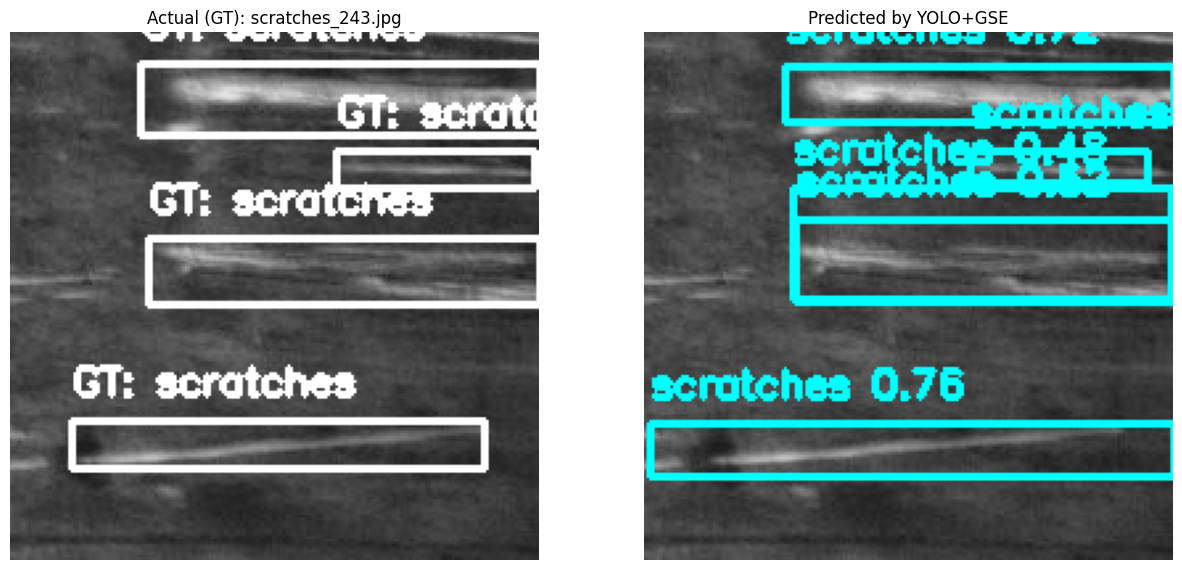

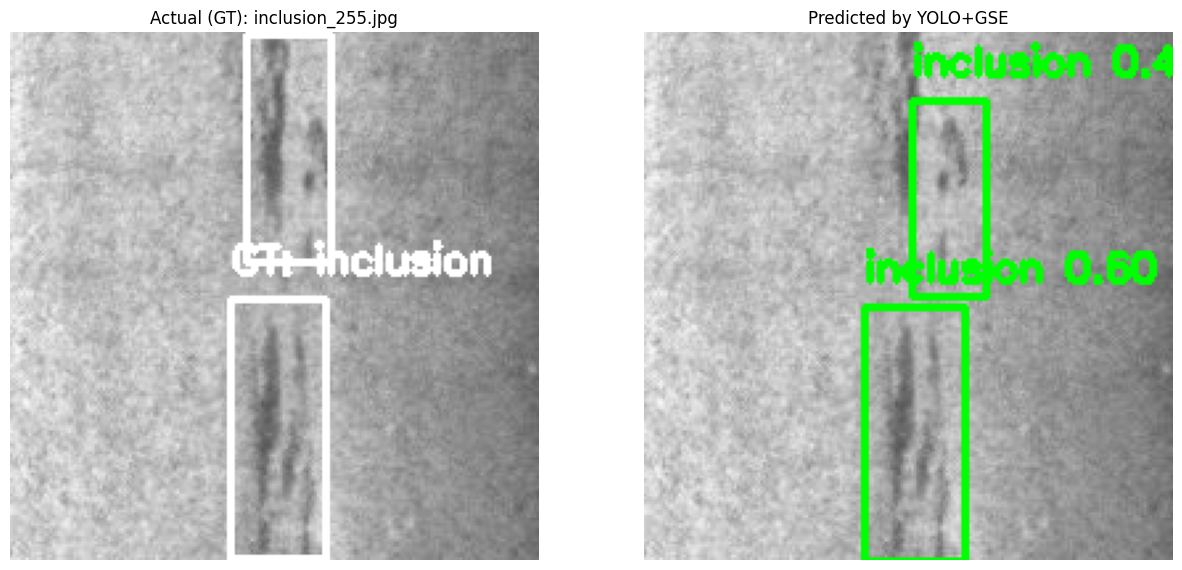

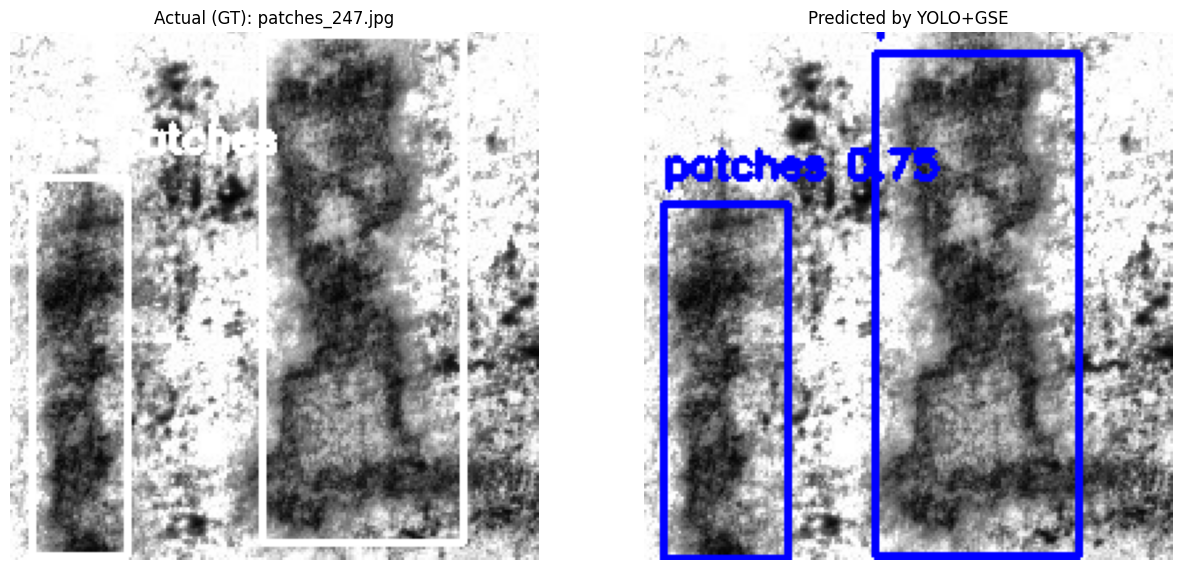

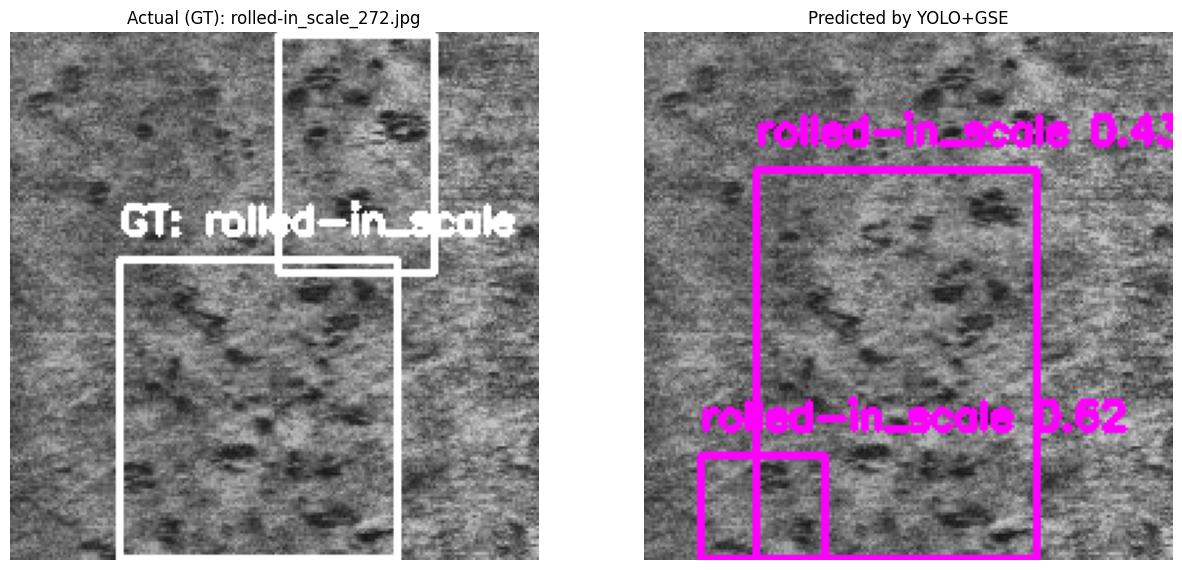

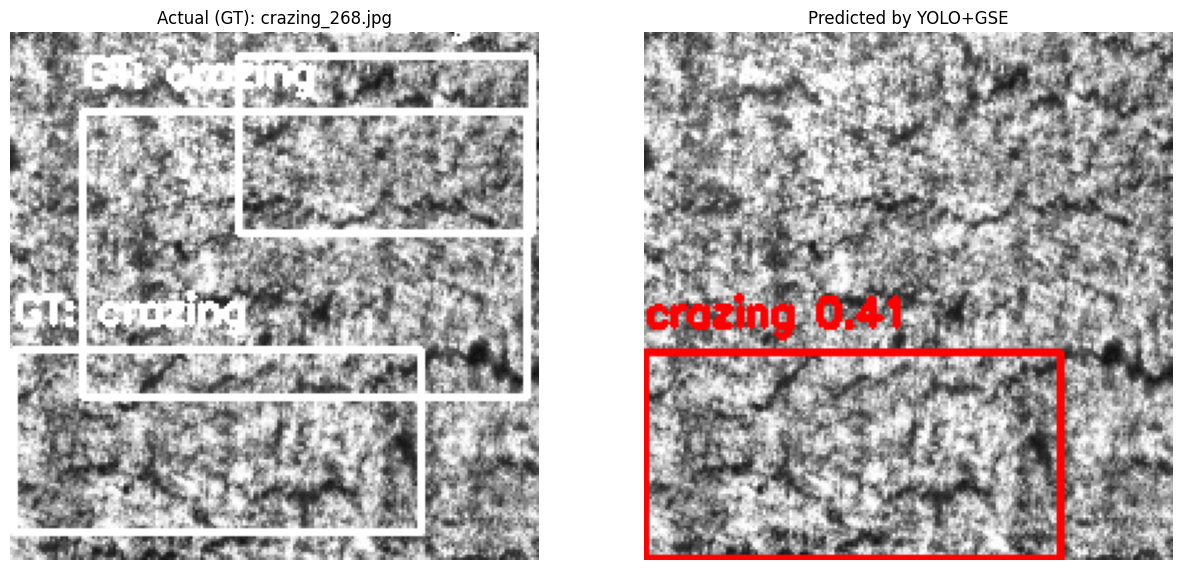

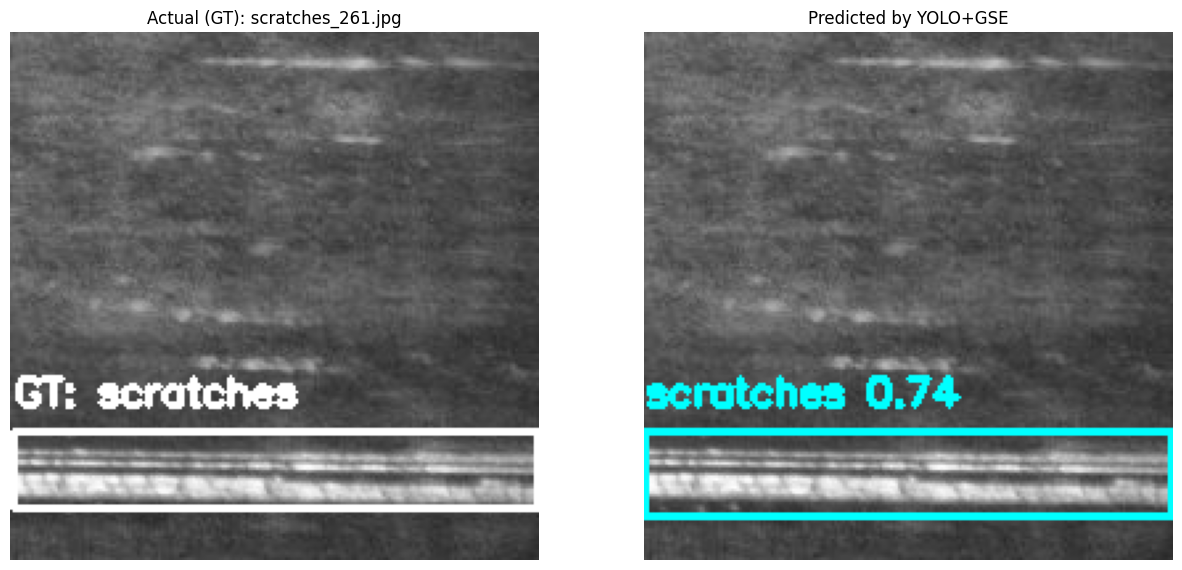

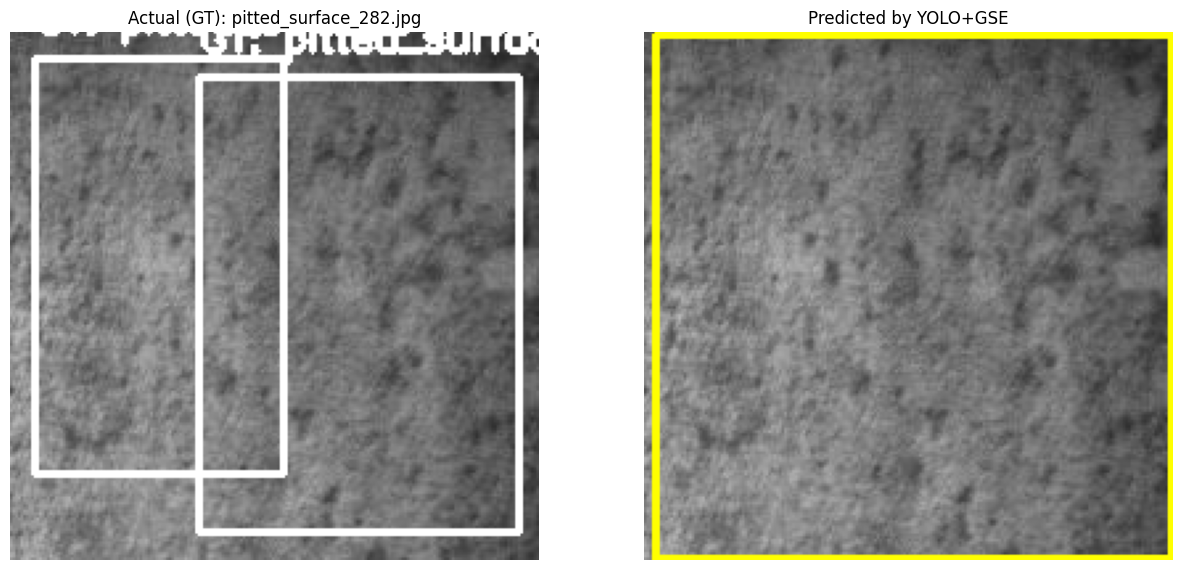

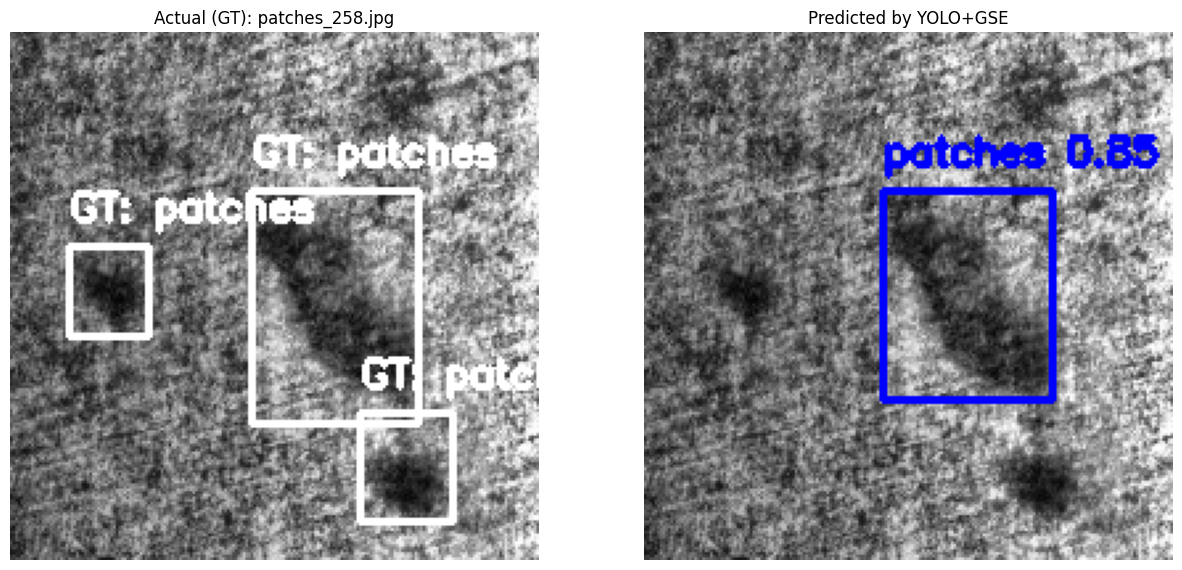

All Images are saved in DRIVE


In [16]:
import os
import random
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

CLASSES = ["crazing", "inclusion", "patches", "pitted_surface", "rolled-in_scale", "scratches"]

COLORS = [
    (255, 0, 0),    # قرمز
    (0, 255, 0),    # سبز
    (0, 0, 255),    # آبی
    (255, 255, 0),  # زرد
    (255, 0, 255),  # بنفش
    (0, 255, 255)   # فیروزه‌ای
]

model_path = "/content/drive/MyDrive/FINAL_Project/Training_Results2/YOLO11m_GSE_1280px2/weights/best.pt"
VAL_IMG_DIR = "dataset_yolo/images/val"
VAL_LBL_DIR = "dataset_yolo/labels/val"
SAVE_DIR = "/content/drive/MyDrive/FINAL_Project/samples"

os.makedirs(SAVE_DIR, exist_ok=True)

model = YOLO(model_path)

def draw_yolo_labels(img, label_path):
    h, w, _ = img.shape
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f.readlines():
                cls, x, y, nw, nh = map(float, line.split())
                x1 = int((x - nw/2) * w)
                y1 = int((y - nh/2) * h)
                x2 = int((x + nw/2) * w)
                y2 = int((y + nh/2) * h)
                cv2.rectangle(img, (x1, y1), (x2, y2), (255, 255, 255), 2)
                cv2.putText(img, f"GT: {CLASSES[int(cls)]}", (x1, y1-10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
    return img

images = [f for f in os.listdir(VAL_IMG_DIR) if f.endswith(('.jpg', '.png'))]
sample_count = 8
sample_images = random.sample(images, sample_count)

print(f"Getting started ... {SAVE_DIR}")

for img_name in sample_images:
    img_path = os.path.join(VAL_IMG_DIR, img_name)
    lbl_path = os.path.join(VAL_LBL_DIR, img_name.replace('.jpg', '.txt'))

    original_img = cv2.imread(img_path)
    if original_img is None:
        continue
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

    gt_img = draw_yolo_labels(original_img.copy(), lbl_path)

    results = model(img_path, conf=0.4, verbose=False)[0]
    pred_img = original_img.copy()

    for box in results.boxes:
        c = int(box.cls)
        conf = float(box.conf)
        xyxy = box.xyxy[0].cpu().numpy().astype(int)

        class_color = COLORS[c]

        cv2.rectangle(pred_img, (xyxy[0], xyxy[1]), (xyxy[2], xyxy[3]), class_color, 2)
        cv2.putText(pred_img, f"{CLASSES[c]} {conf:.2f}", (xyxy[0], xyxy[1]-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, class_color, 2)

    fig, axes = plt.subplots(1, 2, figsize=(15, 7))

    axes[0].imshow(gt_img)
    axes[0].set_title(f"Actual (GT): {img_name}")
    axes[0].axis("off")

    axes[1].imshow(pred_img)
    axes[1].set_title(f"Predicted by YOLO+GSE")
    axes[1].axis("off")

    save_path = os.path.join(SAVE_DIR, img_name)

    plt.savefig(save_path, bbox_inches='tight', dpi=150)
    plt.show()
    plt.close(fig)


print("All Images are saved in DRIVE")

# Fuzzy

In [17]:
!pip install scikit-fuzzy

In [18]:
SAVE_DIR = "/content/drive/MyDrive/FINAL_Project/Fuzzy_System"
os.makedirs(SAVE_DIR, exist_ok=True)

MODEL_PATH = "/content/drive/MyDrive/FINAL_Project/Training_Results2/YOLO11m_GSE_1280px2/weights/best.pt"
VAL_IMG_DIR = "dataset_yolo/images/val"
VAL_LBL_DIR = "dataset_yolo/labels/val"

CLASSES = ["crazing", "inclusion", "patches", "pitted_surface", "rolled-in_scale", "scratches"]
COLORS = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255), (0, 255, 255)]


In [19]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from ultralytics import YOLO


RISK_FACTORS = {
    0: 1.0,  # crazing (High Risk)
    1: 0.9,  # inclusion
    2: 0.6,  # patches
    3: 0.8,  # pitted_surface
    4: 0.5,  # rolled-in_scale
    5: 0.2   # scratches (Low Risk)
}

class AdvancedFuzzyController:
    def __init__(self):

        self.risk_score = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'risk_score')
        self.confidence = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'confidence')
        self.speed_change = ctrl.Consequent(np.arange(-1, 1.01, 0.01), 'speed_change')

        self.risk_score['Low']    = fuzz.gaussmf(self.risk_score.universe, 0, 0.15)
        self.risk_score['Medium'] = fuzz.gaussmf(self.risk_score.universe, 0.5, 0.15)
        self.risk_score['High']   = fuzz.gaussmf(self.risk_score.universe, 1, 0.15)

        self.confidence['Low']    = fuzz.gaussmf(self.confidence.universe, 0, 0.15)
        self.confidence['Medium'] = fuzz.gaussmf(self.confidence.universe, 0.5, 0.15)
        self.confidence['High']   = fuzz.gaussmf(self.confidence.universe, 1, 0.15)

        self.speed_change['Brake']      = fuzz.gaussmf(self.speed_change.universe, -1, 0.25)
        self.speed_change['Maintain']   = fuzz.gaussmf(self.speed_change.universe, 0, 0.15)
        self.speed_change['Accelerate'] = fuzz.gaussmf(self.speed_change.universe, 1, 0.25)

        self.rules = [

            ctrl.Rule(self.risk_score['Low'] & self.confidence['High'], self.speed_change['Accelerate']),
            ctrl.Rule(self.risk_score['Low'] & self.confidence['Medium'], self.speed_change['Accelerate']),
            ctrl.Rule(self.risk_score['Low'] & self.confidence['Low'], self.speed_change['Maintain']),

            ctrl.Rule(self.risk_score['Medium'] & self.confidence['High'], self.speed_change['Brake']),
            ctrl.Rule(self.risk_score['Medium'] & self.confidence['Medium'], self.speed_change['Maintain']),
            ctrl.Rule(self.risk_score['Medium'] & self.confidence['Low'], self.speed_change['Maintain']),

            ctrl.Rule(self.risk_score['High'] & self.confidence['High'], self.speed_change['Brake']),
            ctrl.Rule(self.risk_score['High'] & self.confidence['Medium'], self.speed_change['Brake']),
            ctrl.Rule(self.risk_score['High'] & self.confidence['Low'], self.speed_change['Brake']),
        ]

        self.control_system = ctrl.ControlSystem(self.rules)
        self.simulation = ctrl.ControlSystemSimulation(self.control_system)

    def compute(self, risk_val, conf_val):
        self.simulation.input['risk_score'] = np.clip(risk_val, 0, 1)
        self.simulation.input['confidence'] = np.clip(conf_val, 0, 1)
        self.simulation.compute()
        return self.simulation.output['speed_change']

    def plot_result_manual(self, filename_suffix):

        fig, ax = plt.subplots(figsize=(8, 4))

        x = self.speed_change.universe
        mfs = self.speed_change.terms
        for label, term in mfs.items():
            ax.plot(x, term.mf, label=label)
            ax.fill_between(x, 0, term.mf, alpha=0.1)

        try:
            res = self.simulation.output['speed_change']
            ax.vlines(res, 0, 1, colors='r', linestyles='dashed', linewidth=2, label='Result')
        except:
            pass

        ax.set_title(f"Fuzzy Result: {filename_suffix}")
        ax.legend()

        save_path = os.path.join(SAVE_DIR, f"{filename_suffix}.png")
        plt.savefig(save_path, bbox_inches='tight')
        plt.close(fig)
        print(f"Plots saved: {save_path}")



In [20]:

fuzzy_brain = AdvancedFuzzyController()

scenarios = [
    {"area": 0.85, "conf": 0.90, "name": "Scenario1_HighRisk"},
    {"area": 0.10, "conf": 0.85, "name": "Scenario2_LowRisk"},
    {"area": 0.50, "conf": 0.30, "name": "Scenario3_Ambiguous"}
]

for sc in scenarios:
    res = fuzzy_brain.compute(sc["area"], sc["conf"])
    print(f"Testing {sc['name']}: Risk={sc['area']}, Conf={sc['conf']} --> Speed Change={res:.2f}")
    fname = f"risk_{sc['area']}_conf_{sc['conf']}_result"
    fuzzy_brain.plot_result_manual(fname)

def calculate_weighted_risk(results, img_shape):
    h, w = img_shape[:2]
    total_pixels = h * w
    total_weighted_risk = 0
    confidences = []

    if len(results.boxes) == 0:
        return 0.0, 1.0

    for box in results.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        box_area = (x2 - x1) * (y2 - y1)
        normalized_area = box_area / total_pixels

        cls_id = int(box.cls)
        risk_factor = RISK_FACTORS.get(cls_id, 0.5)

        total_weighted_risk += (normalized_area * risk_factor) * 10
        confidences.append(float(box.conf))

    mean_conf = sum(confidences) / len(confidences)

    return min(total_weighted_risk, 1.0), mean_conf

def draw_gt(img, label_path):
    h, w, _ = img.shape
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f.readlines():
                cls, x, y, nw, nh = map(float, line.split())
                x1, y1 = int((x - nw/2) * w), int((y - nh/2) * h)
                x2, y2 = int((x + nw/2) * w), int((y + nh/2) * h)
                cv2.rectangle(img, (x1, y1), (x2, y2), (255, 255, 255), 2)
                cv2.putText(img, f"GT: {CLASSES[int(cls)]}", (x1, y1-10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
    return img

def draw_pred(img, results):
    for box in results.boxes:
        c = int(box.cls)
        conf = float(box.conf)
        xyxy = box.xyxy[0].cpu().numpy().astype(int)
        color = COLORS[c]
        cv2.rectangle(img, (xyxy[0], xyxy[1]), (xyxy[2], xyxy[3]), color, 2)
        cv2.putText(img, f"{CLASSES[c]} {conf:.2f}", (xyxy[0], xyxy[1]-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    return img


model = YOLO(MODEL_PATH)
all_images = [f for f in os.listdir(VAL_IMG_DIR) if f.endswith(('.jpg', '.png'))]

sample_images = random.sample(all_images, min(3, len(all_images)))

for img_name in sample_images:
    img_path = os.path.join(VAL_IMG_DIR, img_name)
    lbl_path = os.path.join(VAL_LBL_DIR, img_name.replace('.jpg', '.txt'))

    original_img = cv2.imread(img_path)
    if original_img is None: continue
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

    results = model(img_path, conf=0.25, verbose=False)[0]

    calc_risk, calc_conf = calculate_weighted_risk(results, original_img.shape)

    fuzzy_output = fuzzy_brain.compute(calc_risk, calc_conf)

    gt_img = draw_gt(original_img.copy(), lbl_path)
    pred_img = draw_pred(original_img.copy(), results)

    fig = plt.figure(figsize=(18, 10))
    gs = fig.add_gridspec(2, 2)

    ax1 = fig.add_subplot(gs[0, 0])
    ax1.imshow(gt_img)
    ax1.set_title(f"Ground Truth: {img_name}", fontsize=12, fontweight='bold')
    ax1.axis("off")

    ax2 = fig.add_subplot(gs[0, 1])
    ax2.imshow(pred_img)
    ax2.set_title(f"YOLOv8 Detection", fontsize=12, fontweight='bold')
    ax2.axis("off")

    ax3 = fig.add_subplot(gs[1, 0])
    ax3.axis("off")
    decision_text = 'ACCELERATE'
    if fuzzy_output < -0.1: decision_text = 'BRAKE (Slow Down)'
    elif fuzzy_output < 0.1: decision_text = 'MAINTAIN'

    text_info = (
        f"--- Fuzzy Input Analysis ---\n\n"
        f"1. Weighted Risk Score: {calc_risk:.3f} (0 to 1)\n"
        f"2. Mean Confidence:     {calc_conf*100:.1f}%\n\n"
        f"--- Fuzzy Output Decision ---\n\n"
        f"SPEED CHANGE FACTOR:    {fuzzy_output:.3f}\n"
        f"Decision: {decision_text}"
    )
    ax3.text(0.1, 0.5, text_info, fontsize=14, va='center', ha='left',
             bbox=dict(boxstyle="round,pad=0.5", fc="#f0f0f0", ec="black", alpha=0.9))

    ax4 = fig.add_subplot(gs[1, 1])
    x = fuzzy_brain.speed_change.universe
    mfs = fuzzy_brain.speed_change.terms
    for label, term in mfs.items():
        ax4.plot(x, term.mf, label=label, linewidth=1.5)
        ax4.fill_between(x, 0, term.mf, alpha=0.1)

    ax4.vlines(fuzzy_output, 0, 1, colors='r', linestyles='dashed', linewidth=3, label='Result')
    ax4.set_title("Fuzzy Speed Control Logic", fontsize=12, fontweight='bold')
    ax4.legend(loc='upper right')
    ax4.grid(True, alpha=0.3)

    save_path = os.path.join(SAVE_DIR, img_name)
    plt.savefig(save_path, bbox_inches='tight', dpi=100)
    plt.close(fig)
    print(f"All saved : {save_path}")

print(f"Ouput plots path: \n{SAVE_DIR}")

Testing Scenario1_HighRisk: Risk=0.85, Conf=0.9 --> Speed Change=-0.71
Plots saved: /content/drive/MyDrive/FINAL_Project/Fuzzy_System/risk_0.85_conf_0.9_result.png
Testing Scenario2_LowRisk: Risk=0.1, Conf=0.85 --> Speed Change=0.63
Plots saved: /content/drive/MyDrive/FINAL_Project/Fuzzy_System/risk_0.1_conf_0.85_result.png
Testing Scenario3_Ambiguous: Risk=0.5, Conf=0.3 --> Speed Change=0.00
Plots saved: /content/drive/MyDrive/FINAL_Project/Fuzzy_System/risk_0.5_conf_0.3_result.png
All saved : /content/drive/MyDrive/FINAL_Project/Fuzzy_System/crazing_245.jpg
All saved : /content/drive/MyDrive/FINAL_Project/Fuzzy_System/pitted_surface_273.jpg
All saved : /content/drive/MyDrive/FINAL_Project/Fuzzy_System/patches_261.jpg
Ouput plots path: 
/content/drive/MyDrive/FINAL_Project/Fuzzy_System


# create video

In [21]:
import cv2
import os
import numpy as np

IMG_DIR = "dataset_yolo/images/val"
VIDEO_PATH = "/content/raw_simulation.mp4"

fps = 5
frame_size = (640, 640)

images = [img for img in os.listdir(IMG_DIR) if img.endswith(".jpg") or img.endswith(".png")]
images.sort()

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(VIDEO_PATH, fourcc, fps, frame_size)

print(f"Creating video from {len(images)} images of validation...")

for img_name in images:
    path = os.path.join(IMG_DIR, img_name)
    frame = cv2.imread(path)
    if frame is not None:
        frame = cv2.resize(frame, frame_size)
        for _ in range(4):
            out.write(frame)

out.release()
print(f"Video created: {VIDEO_PATH}")

destination_dir = "/content/drive/MyDrive/FINAL_Project/simulated_video/"

import shutil
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)
    print(f"Created new directory: {destination_dir}")
else:
    print(f"Directory already exists: {destination_dir}")

try:
    shutil.copy(VIDEO_PATH, destination_dir)
    print(f"✅ Video successfully copied to: {destination_dir}")
except Exception as e:
    print(f"❌ Error copying file: {e}")

Creating video from 360 images of validation...
Video created: /content/raw_simulation.mp4
Directory already exists: /content/drive/MyDrive/FINAL_Project/simulated_video/
✅ Video successfully copied to: /content/drive/MyDrive/FINAL_Project/simulated_video/


In [22]:
import time
from tqdm import tqdm

INPUT_VIDEO = "/content/drive/MyDrive/FINAL_Project/simulated_video/raw_simulation.mp4"
OUTPUT_VIDEO = "/content/drive/MyDrive/FINAL_Project/Fuzzy_System/smart_conveyor_simulation.mp4"
SAVE_PLOT_PATH = "/content/drive/MyDrive/FINAL_Project/Fuzzy_System/speed_analysis.png"
CURRENT_SPEED = 0.5
MIN_SPEED = 0.1
MAX_SPEED = 1.0
SPEED_INERTIA = 0.1

history_speed = []
history_risk = []
history_conf = []

def apply_motion_blur(image, speed):

    factor = 20
    kernel_size = int(speed * factor)

    if kernel_size < 1:
        return image

    kernel_motion_blur = np.zeros((kernel_size, kernel_size))
    kernel_motion_blur[int((kernel_size-1)/2), :] = np.ones(kernel_size)
    kernel_motion_blur /= kernel_size

    return cv2.filter2D(image, -1, kernel_motion_blur)




In [23]:
fuzzy_brain = AdvancedFuzzyController()
model = YOLO("/content/drive/MyDrive/FINAL_Project/Training_Results2/YOLO11m_GSE_1280px2/weights/best.pt")
cap = cv2.VideoCapture(INPUT_VIDEO)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

out_sim = cv2.VideoWriter(OUTPUT_VIDEO, cv2.VideoWriter_fourcc(*'mp4v'), 5, (width, height))

print(f"Starting closed loop simulation on {total_frames} frames...")

for i in tqdm(range(total_frames)):
    ret, frame = cap.read()
    if not ret: break

    blurred_frame = apply_motion_blur(frame.copy(), CURRENT_SPEED)

    results = model(blurred_frame, conf=0.25, verbose=False)[0]

    risk_score, mean_conf = calculate_weighted_risk(results, frame.shape)

    speed_change_factor = fuzzy_brain.compute(risk_score, mean_conf)

    target_speed = CURRENT_SPEED + (speed_change_factor * 0.1)

    CURRENT_SPEED = np.clip(target_speed, MIN_SPEED, MAX_SPEED)

    history_speed.append(CURRENT_SPEED)
    history_risk.append(risk_score)
    history_conf.append(mean_conf)

    annotated_frame = blurred_frame.copy()
    annotated_frame = draw_pred(annotated_frame, results)


    cv2.rectangle(annotated_frame, (0, 0), (width, 80), (0, 0, 0), -1)

    speed_color = (0, 255, 0) if CURRENT_SPEED > 0.7 else (0, 165, 255) if CURRENT_SPEED > 0.4 else (0, 0, 255)
    cv2.putText(annotated_frame, f"SPEED: {CURRENT_SPEED*100:.1f}%", (20, 50),
                cv2.FONT_HERSHEY_SIMPLEX, 1, speed_color, 3)

    cv2.putText(annotated_frame, f"RISK: {risk_score:.2f}", (300, 50),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

    action = "BRAKE" if speed_change_factor < -0.1 else "ACCEL" if speed_change_factor > 0.1 else "HOLD"
    cv2.putText(annotated_frame, f"ACT: {action}", (500, 50),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)

    out_sim.write(annotated_frame)

cap.release()
out_sim.release()
print(f"Simulation is Done and video saved in: {OUTPUT_VIDEO}")



Starting closed loop simulation on 1440 frames...


100%|██████████| 1440/1440 [00:56<00:00, 25.67it/s]

Simulation is Done and video saved in: /content/drive/MyDrive/FINAL_Project/Fuzzy_System/smart_conveyor_simulation.mp4


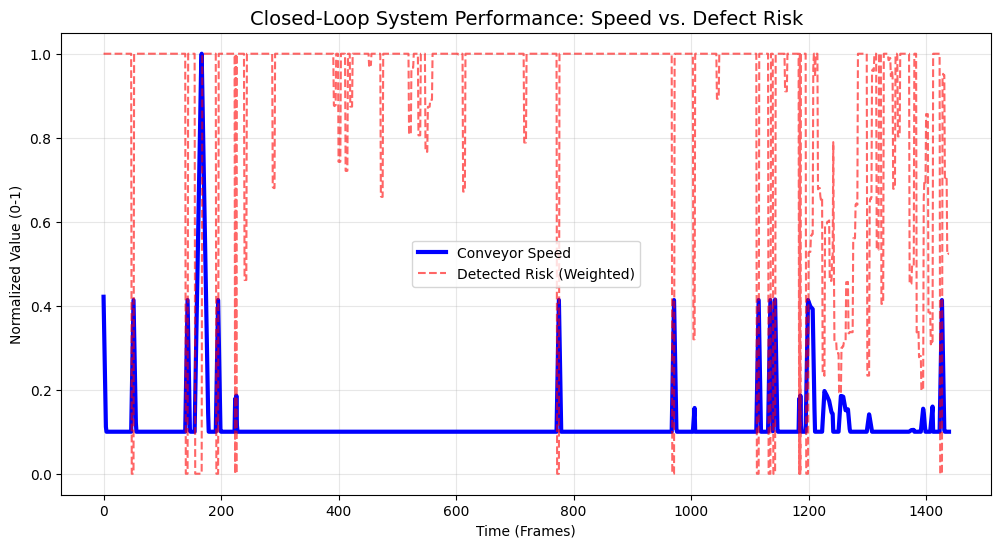

The plot is saved in: /content/drive/MyDrive/FINAL_Project/Fuzzy_System/speed_analysis.png


In [24]:

plt.figure(figsize=(12, 6))

plt.plot(history_speed, label='Conveyor Speed', color='blue', linewidth=3)
plt.plot(history_risk, label='Detected Risk (Weighted)', color='red', alpha=0.6, linestyle='--')

plt.title('Closed-Loop System Performance: Speed vs. Defect Risk', fontsize=14)
plt.xlabel('Time (Frames)')
plt.ylabel('Normalized Value (0-1)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(SAVE_PLOT_PATH)
plt.show()

print(f"The plot is saved in: {SAVE_PLOT_PATH}")

# RL

In [25]:
import numpy as np
import pickle
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from ultralytics import YOLO
import skfuzzy as fuzz
from skfuzzy import control as ctrl

INPUT_VIDEO = "/content/drive/MyDrive/FINAL_Project/simulated_video/raw_simulation.mp4"
MODEL_PATH = "/content/drive/MyDrive/FINAL_Project/Training_Results2/YOLO11m_GSE_1280px2/weights/best.pt"


RL_MODEL_SAVE_PATH = "/content/drive/MyDrive/FINAL_Project/RL/hybrid_rl_model.pkl"
EPISODES = 100

model = YOLO(MODEL_PATH)



class HybridRLAgent:
    def __init__(self, learning_rate=0.1, discount_factor=0.9, epsilon=1.0, epsilon_decay=0.93):
        self.q_table = np.zeros((3, 3, 3))
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay

        self.actions = {0: -0.1, 1: 0.0, 2: 0.1}

    def get_state(self, fuzzy_output, current_speed):
        if fuzzy_output < -0.1: fuzzy_state = 0
        elif fuzzy_output > 0.1: fuzzy_state = 2
        else: fuzzy_state = 1

        if current_speed < 0.3: speed_state = 0
        elif current_speed < 0.7: speed_state = 1
        else: speed_state = 2

        return (fuzzy_state, speed_state)

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, 3)
        return np.argmax(self.q_table[state])

    def learn(self, state, action, reward, next_state):
        old_value = self.q_table[state][action]
        next_max = np.max(self.q_table[next_state])
        new_value = (1 - self.lr) * old_value + self.lr * (reward + self.gamma * next_max)
        self.q_table[state][action] = new_value

def calculate_reward_aggressive(speed, risk, action, fuzzy_suggestion):
    reward = 0
    reward += speed * 100

    if risk > 0.4:
        penalty = (risk * speed) * 300
        reward -= penalty

    if fuzzy_suggestion < -0.1: sugg_idx = 0
    elif fuzzy_suggestion > 0.1: sugg_idx = 2
    else: sugg_idx = 1

    if action == sugg_idx:
        reward += 50
    else:
        reward -= 50

    return reward

RISK_FACTORS = {0: 1.0, 1: 0.9, 2: 0.6, 3: 0.8, 4: 0.5, 5: 0.2}
def calculate_weighted_risk(results, img_shape):
    h, w = img_shape[:2]
    total_weighted_risk = 0
    confidences = []
    if len(results.boxes) == 0: return 0.0, 1.0
    for box in results.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        normalized_area = ((x2 - x1) * (y2 - y1)) / (h * w)
        cls_id = int(box.cls)
        total_weighted_risk += (normalized_area * RISK_FACTORS.get(cls_id, 0.5)) * 10
        confidences.append(float(box.conf))
    return min(total_weighted_risk, 1.0), sum(confidences) / len(confidences)

def apply_motion_blur(image, speed):
    factor = 20
    kernel_size = int(speed * factor)
    if kernel_size < 1: return image
    kernel_motion_blur = np.zeros((kernel_size, kernel_size))
    kernel_motion_blur[int((kernel_size-1)/2), :] = np.ones(kernel_size)
    kernel_motion_blur /= kernel_size
    return cv2.filter2D(image, -1, kernel_motion_blur)



In [26]:
if os.path.exists(RL_MODEL_SAVE_PATH):
    try:
        os.remove(RL_MODEL_SAVE_PATH)
        print("The previous version of model has been deleted.")
    except OSError:
        print("couldn't remove the previous model. The new model will be overwrited")

fuzzy_brain = AdvancedFuzzyController()
rl_agent = HybridRLAgent()

print(f"Train hybrid RL model and save in: {RL_MODEL_SAVE_PATH}")

cap_check = cv2.VideoCapture(INPUT_VIDEO)
total_frames = int(cap_check.get(cv2.CAP_PROP_FRAME_COUNT))
cap_check.release()

for episode in range(EPISODES):
    cap = cv2.VideoCapture(INPUT_VIDEO)
    current_speed = 0.5
    total_reward = 0

    ret, frame = cap.read()
    if not ret: break

    results = model(frame, conf=0.25, verbose=False)[0]
    risk, conf = calculate_weighted_risk(results, frame.shape)
    fuzzy_suggestion = fuzzy_brain.compute(risk, conf)
    state = rl_agent.get_state(fuzzy_suggestion, current_speed)

    cached_risk, cached_conf = risk, conf

    for _ in range(total_frames - 1):
        ret, next_frame = cap.read()
        if not ret: break

        action_idx = rl_agent.choose_action(state)
        speed_change = rl_agent.actions[action_idx]
        new_speed = np.clip(current_speed + speed_change, 0.1, 1.0)

        if _ % 3 == 0:
            blurred_frame = apply_motion_blur(next_frame, new_speed)
            results = model(blurred_frame, conf=0.25, verbose=False)[0]
            cached_risk, cached_conf = calculate_weighted_risk(results, next_frame.shape)

        next_risk, next_conf = cached_risk, cached_conf

        reward = calculate_reward_aggressive(new_speed, next_risk, action_idx, fuzzy_suggestion)
        total_reward += reward

        next_fuzzy_suggestion = fuzzy_brain.compute(next_risk, next_conf)
        next_state = rl_agent.get_state(next_fuzzy_suggestion, new_speed)
        rl_agent.learn(state, action_idx, reward, next_state)

        state = next_state
        fuzzy_suggestion = next_fuzzy_suggestion
        current_speed = new_speed

    cap.release()
    rl_agent.epsilon = max(0.05, rl_agent.epsilon * rl_agent.epsilon_decay)

    if (episode+1) % 10 == 0:
        print(f"Ep {episode+1}/{EPISODES} | Reward: {total_reward:.0f} | Epsilon: {rl_agent.epsilon:.2f} | End Speed: {current_speed:.2f}")



The previous version of model has been deleted.
Train hybrid RL model and save in: /content/drive/MyDrive/FINAL_Project/RL/hybrid_rl_model.pkl
Ep 10/100 | Reward: -11790 | Epsilon: 0.48 | End Speed: 0.10
Ep 20/100 | Reward: 18655 | Epsilon: 0.23 | End Speed: 0.10
Ep 30/100 | Reward: 32221 | Epsilon: 0.11 | End Speed: 0.10
Ep 40/100 | Reward: 39137 | Epsilon: 0.05 | End Speed: 0.20
Ep 50/100 | Reward: 41246 | Epsilon: 0.05 | End Speed: 0.10
Ep 60/100 | Reward: 39984 | Epsilon: 0.05 | End Speed: 0.10
Ep 70/100 | Reward: 38967 | Epsilon: 0.05 | End Speed: 0.10
Ep 80/100 | Reward: 40623 | Epsilon: 0.05 | End Speed: 0.10
Ep 90/100 | Reward: 40309 | Epsilon: 0.05 | End Speed: 0.10
Ep 100/100 | Reward: 39704 | Epsilon: 0.05 | End Speed: 0.10


In [27]:
import shutil
if not os.path.exists("/content/drive/MyDrive/FINAL_Project/RL/"):
    os.makedirs("/content/drive/MyDrive/FINAL_Project/RL/")
    print(f"Created new directory: {"/content/drive/MyDrive/FINAL_Project/RL/"}")
else:
    print(f"Directory already exists: {"/content/drive/MyDrive/FINAL_Project/RL/"}")

with open(RL_MODEL_SAVE_PATH, 'wb') as f:
    pickle.dump(rl_agent.q_table, f)

print(f"Model saved in: \n{RL_MODEL_SAVE_PATH}")

Directory already exists: /content/drive/MyDrive/FINAL_Project/RL/
Model saved in: 
/content/drive/MyDrive/FINAL_Project/RL/hybrid_rl_model.pkl


In [28]:
import pickle
import os


RL_MODEL_PATH = "/content/drive/MyDrive/FINAL_Project/RL/hybrid_rl_model.pkl"
OUTPUT_RL_VIDEO = "/content/drive/MyDrive/FINAL_Project/RL/hybrid_rl_smart_conveyor.mp4"
SAVE_PLOT_PATH = "/content/drive/MyDrive/FINAL_Project/RL/hybrid_rl_performance.png"

rl_agent = HybridRLAgent()

if os.path.exists(RL_MODEL_PATH):
    with open(RL_MODEL_PATH, 'rb') as f:
        rl_agent.q_table = pickle.load(f)
    print(f"RL model successfully loaded from: {RL_MODEL_PATH}")
else:
    print("Not found.")
    raise FileNotFoundError("Model file not found")

rl_agent.epsilon = 0

cap = cv2.VideoCapture(INPUT_VIDEO)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out_rl = cv2.VideoWriter(OUTPUT_RL_VIDEO, cv2.VideoWriter_fourcc(*'mp4v'), 5, (width, height))

current_speed = 0.5
risk_log, speed_log = [], []

print("Creating Final video...")

ret, frame = cap.read()
if ret:
    results = model(frame, conf=0.25, verbose=False)[0]
    risk, conf = calculate_weighted_risk(results, frame.shape)

    fuzzy_suggestion = fuzzy_brain.compute(risk, conf)
    state = rl_agent.get_state(fuzzy_suggestion, current_speed)

print("Max value in Q-Table:", np.max(rl_agent.q_table))
print("Non-zero elements:", np.count_nonzero(rl_agent.q_table))
while True:
    action_idx = rl_agent.choose_action(state)
    speed_change = rl_agent.actions[action_idx]
    if np.random.rand() < 0.05:
        print(f"Speed: {current_speed:.2f} | Fuzzy: {fuzzy_suggestion:.2f} | RL Action: {action_idx} | Q-Values: {rl_agent.q_table[state]}")

    if np.all(rl_agent.q_table[state] == 0):
        print("All values are zero. weather the model couldn't learn any thing or nothing is loaded from table")
        break
    current_speed = np.clip(current_speed + speed_change, 0.1, 1.0)

    ret, frame = cap.read()
    if not ret: break

    blurred_frame = apply_motion_blur(frame, current_speed)
    results = model(blurred_frame, conf=0.25, verbose=False)[0]
    risk, conf = calculate_weighted_risk(results, frame.shape)

    fuzzy_suggestion = fuzzy_brain.compute(risk, conf)
    state = rl_agent.get_state(fuzzy_suggestion, current_speed)

    annotated = draw_pred(blurred_frame.copy(), results)

    cv2.rectangle(annotated, (0, 0), (width, 100), (0, 0, 0), -1)

    color_speed = (0, 255, 0) if current_speed > 0.7 else (0, 0, 255)
    cv2.putText(annotated, f"SPEED: {current_speed*100:.0f}%", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color_speed, 2)

    cv2.putText(annotated, f"RISK: {risk:.2f}", (250, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

    fuz_text = "BRAKE" if fuzzy_suggestion < -0.1 else "ACCEL" if fuzzy_suggestion > 0.1 else "HOLD"
    cv2.putText(annotated, f"Fuzzy: {fuz_text}", (20, 80), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (200, 200, 200), 1)

    action_name = ["BRAKE", "HOLD", "ACCEL"][action_idx]
    color_act = (0, 255, 255) if action_name == fuz_text else (0, 0, 255)
    cv2.putText(annotated, f"RL Action: {action_name}", (250, 80), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color_act, 2)

    out_rl.write(annotated)

    risk_log.append(risk)
    speed_log.append(current_speed)

cap.release()
out_rl.release()
print(f"Final video saved in: {OUTPUT_RL_VIDEO}")



RL model successfully loaded from: /content/drive/MyDrive/FINAL_Project/RL/hybrid_rl_model.pkl
Creating Final video...
Max value in Q-Table: 471.07648944013323
Non-zero elements: 27
Speed: 0.10 | Fuzzy: -0.79 | RL Action: 0 | Q-Values: [     371.31       220.3      204.73]
Speed: 0.10 | Fuzzy: -0.76 | RL Action: 0 | Q-Values: [     371.31       220.3      204.73]
Speed: 0.10 | Fuzzy: -0.79 | RL Action: 0 | Q-Values: [     371.31       220.3      204.73]
Speed: 0.40 | Fuzzy: 0.78 | RL Action: 2 | Q-Values: [     230.36      196.57      278.58]
Speed: 0.10 | Fuzzy: -0.79 | RL Action: 0 | Q-Values: [     371.31       220.3      204.73]
Speed: 0.10 | Fuzzy: -0.77 | RL Action: 0 | Q-Values: [     371.31       220.3      204.73]
Speed: 0.10 | Fuzzy: -0.72 | RL Action: 0 | Q-Values: [     371.31       220.3      204.73]
Speed: 0.10 | Fuzzy: -0.77 | RL Action: 0 | Q-Values: [     371.31       220.3      204.73]
Speed: 0.10 | Fuzzy: -0.77 | RL Action: 0 | Q-Values: [     371.31       220.3     

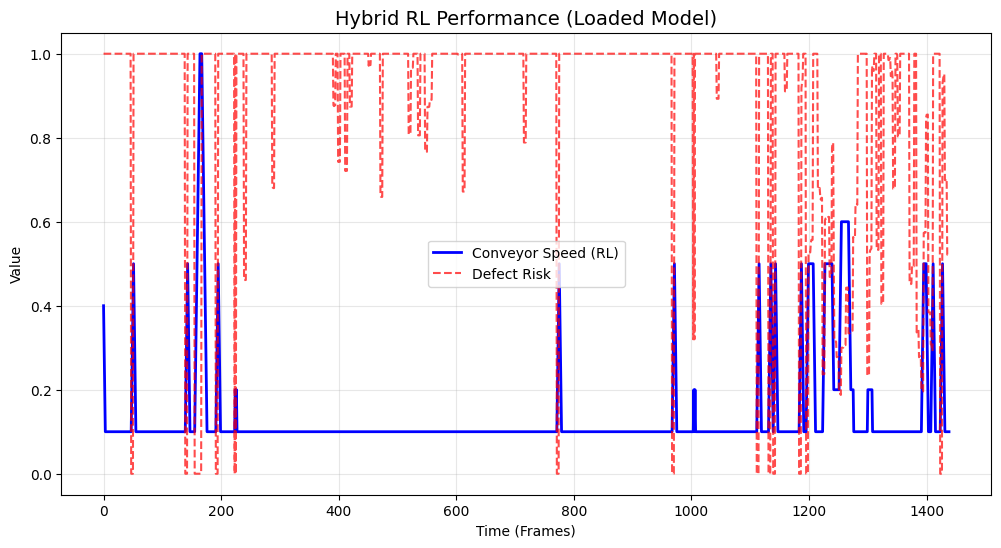

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(speed_log, label='Conveyor Speed (RL)', color='blue', linewidth=2)
plt.plot(risk_log, label='Defect Risk', color='red', linestyle='--', alpha=0.7)
plt.title("Hybrid RL Performance (Loaded Model)", fontsize=14)
plt.xlabel("Time (Frames)")
plt.ylabel("Value")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(SAVE_PLOT_PATH)
plt.show()